In [425]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%pip install pygal
import pygal
# from pygal.maps.world import COUNTRIES

import warnings
warnings.filterwarnings('ignore')

In [426]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **RESEARCH QUESTIONS**


1. Do the number of medals on the average increase as an athlete participates more?
2. What is the relation between the number of medals and the number of each medal individually?
3. Does the economy of the country affect their performance?
4. What is the estimated number of appearances for a participant to achieve their first medal?
5. What are the performances of both genders?
6. How does hosting events affect a country's performance?
7. What is the peak age per sport?
8. What is the average time for winning the first medal since joining?
9. What is the relation between the number of participants from a country and number of medals relative to the country's population?


# **READING THE DATA**

Reading the two raw datasets, regions and athletes datasets.

In [427]:
df_olympics_raw = pd.read_csv('/content/drive/MyDrive/Data Engineering/dataset/athlete_events.csv')
df_regions_raw = pd.read_csv('/content/drive/MyDrive/Data Engineering/dataset/noc_regions.csv')

print(len(df_olympics_raw))
df_regions_raw.info()

271116
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB


At the beginning we read the two datasets, athletes and regions. As we were exploring the data, we considered joining the athlete dataset with the regions dataset on the NOC attribute which was found in both datasets. Yet, we found out that the number of data objects were reduced after merging the two datasets. We then figured out that this behaviour was a result of several objects with the attribute NOC equal to SGP that did not appear in regions dataset. But also we had a SIN attribute that appeared in regions but not athletes dataset. Where both were actually representing the same country, hence we replaced SGP regions with SIN and merged data.


In [428]:
# Getting unique values in both
olymicsNOC = df_olympics_raw['NOC'].unique()
regionsNOC = df_regions_raw['NOC'].unique()

print("Elements in  athletes dataset but not in regions dataset")
for noc in olymicsNOC:
  if noc not in regionsNOC:
    print(noc)

print("")

print("Elements in  regions dataset but not in athletes dataset")
for noc in regionsNOC:
  if noc not in olymicsNOC :
    print(noc)

print("")

# We only care about the elements that were in athletes dataset without a matching region
noMatch = df_olympics_raw[df_olympics_raw['NOC']=='SGP']
print("Number of elements with missing a matching region in athletes dataset:", len(noMatch))


Elements in  athletes dataset but not in regions dataset
SGP

Elements in  regions dataset but not in athletes dataset
SIN

Number of elements with missing a matching region in athletes dataset: 349


Merging the datasets after filling the missing NOC records

In [429]:
# Replacing SIN with SGP as this is the element found in athletes dataset
df_regions = df_regions_raw
df_regions['region'].replace('SIN','SGP',inplace=True)
df_olympics = pd.merge(df_olympics_raw, df_regions, left_on = 'NOC',right_on = 'NOC')

In [430]:
df_olympics.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,602,Abudoureheman,M,22.0,182.0,75.0,China,CHN,2000 Summer,2000,Summer,Sydney,Boxing,Boxing Men's Middleweight,NaN,China,NaN
3,1463,Ai Linuer,M,25.0,160.0,62.0,China,CHN,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Men's Lightweight, Greco-Roman",NaN,China,NaN
4,1464,Ai Yanhan,F,14.0,168.0,54.0,China,CHN,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Women's 200 metres Freestyle,NaN,China,NaN


In [431]:
df_olympics.shape

(270767, 17)

In [432]:
df_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270767 entries, 0 to 270766
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      270767 non-null  int64  
 1   Name    270767 non-null  object 
 2   Sex     270767 non-null  object 
 3   Age     261305 non-null  float64
 4   Height  210684 non-null  float64
 5   Weight  207982 non-null  float64
 6   Team    270767 non-null  object 
 7   NOC     270767 non-null  object 
 8   Games   270767 non-null  object 
 9   Year    270767 non-null  int64  
 10  Season  270767 non-null  object 
 11  City    270767 non-null  object 
 12  Sport   270767 non-null  object 
 13  Event   270767 non-null  object 
 14  Medal   39774 non-null   object 
 15  region  270746 non-null  object 
 16  notes   5039 non-null    object 
dtypes: float64(3), int64(2), object(12)
memory usage: 37.2+ MB


In [433]:
df_olympics.describe()

,ID,Age,Height,Weight,Year
count,270767.000000,261305.000000,210684.000000,207982.000000,270767.000000
mean,68229.276832,25.559783,175.344250,70.709523,1978.362297
std,39017.998824,6.392501,10.519556,14.350094,29.884637
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34630.500000,21.000000,168.000000,60.000000,1960.000000
50%,68187.000000,24.000000,175.000000,70.000000,1988.000000
75%,102065.500000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


In [434]:
df_olympics.nunique()

ID        135404
Name      134566
Sex            2
Age           74
Height        95
Weight       220
Team        1179
NOC          229
Games         51
Year          35
Season         2
City          42
Sport         66
Event        765
Medal          3
region       205
notes         21
dtype: int64

# **EDA**

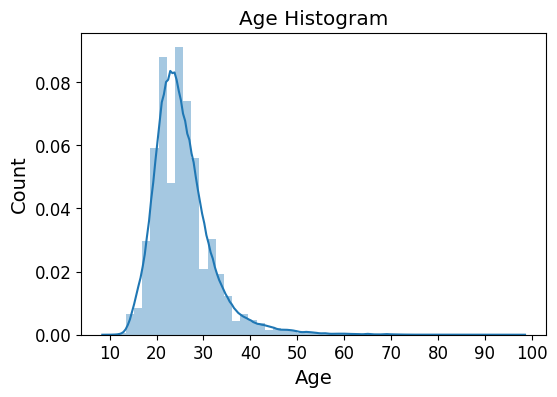

In [435]:
#plot a histogram of age 
bins = [0,10,20,30,40,50,60,70,80,90,100]#the intervals (bins) of the histogram
fig, axs_1 = plt.subplots(1,1,dpi=100)
axs_1.set_title('Age Histogram')
axs_1.set_xlabel('Age')
axs_1.set_xticks(bins)
# axs_3.set_xlim([35,90]) #zoom in, or show me a certain area on the graph 
axs_1.set_ylabel('Count')
sns.distplot(df_olympics['Age'])#a numpy array that has the ages of each passenger who survived (all ages not only unique values)

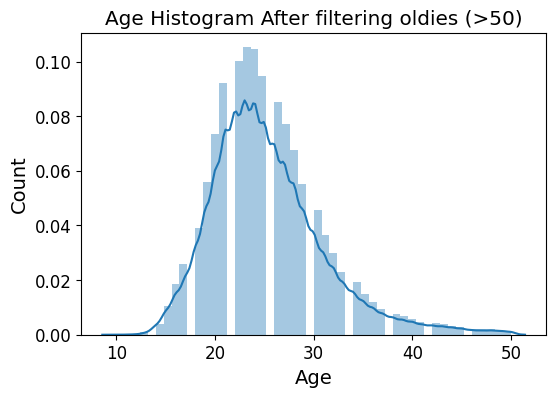

In [436]:
df_filtered_ages_olympics_50=df_olympics[df_olympics['Age']<=50] #removed 0.7%

#plot a histogram of age 
bins = [0,10,20,30,40,50,60,70,80,90,100]#the intervals (bins) of the histogram
fig, axs_1 = plt.subplots(1,1,dpi=100)
axs_1.set_title('Age Histogram After filtering oldies (>50)')
axs_1.set_xlabel('Age')
axs_1.set_xticks(bins)
# axs_3.set_xlim([35,90]) #zoom in, or show me a certain area on the graph 
axs_1.set_ylabel('Count')
sns.distplot(df_filtered_ages_olympics_50['Age'])#a numpy array that has the ages of each passenger who survived (all ages not only unique values)

In [437]:
df_olympics[df_olympics['Age']==97]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
32196,128719,John Quincy Adams Ward,M,97.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",NaN,USA,NaN


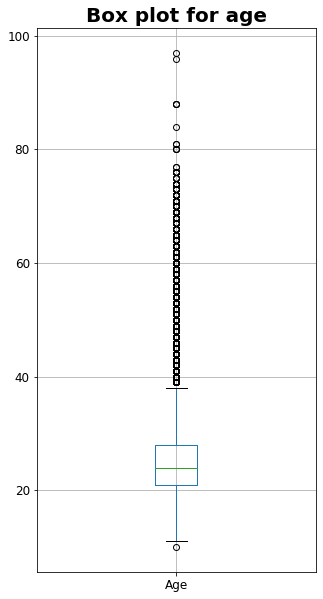

In [438]:
fig, ax = plt.subplots(1, figsize = (5,10))
df_olympics.boxplot(ax=ax, column=['Age'])
plt.title('Box plot for age', fontsize = 20, fontweight="bold")
plt.show()

# df_olympics.boxplot(column =['Age'], grid = False, figsize=(10,10))

(array([6.9000e+01, 7.8700e+02, 6.1980e+03, 3.4586e+04, 7.3029e+04,
        6.6771e+04, 2.4641e+04, 4.0980e+03, 4.6200e+02, 4.3000e+01]),
 array([127. , 136.9, 146.8, 156.7, 166.6, 176.5, 186.4, 196.3, 206.2,
        216.1, 226. ]),
 <a list of 10 Patch objects>)

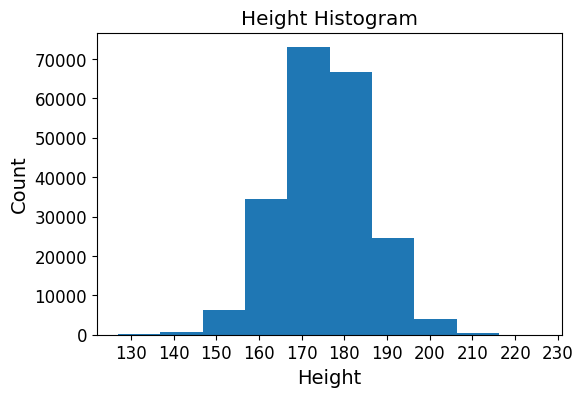

In [439]:
 #plot a histogram of age 
bins = np.arange(0,260,10)#the intervals (bins) of the histogram
fig, axs_1 = plt.subplots(1,1,dpi=100)
axs_1.set_title('Height Histogram')
axs_1.set_xlabel('Height')
axs_1.set_xticks(bins)
# axs_3.set_xlim([35,90]) #zoom in, or show me a certain area on the graph 
axs_1.set_ylabel('Count')
axs_1.hist(df_olympics['Height'],width=10)#a numpy array that has the ages of each passenger who survived (all ages not only unique values)

In [440]:
#multiple NOCs belong to the same region
print(df_regions.shape)
print(len(df_regions['region'].unique()))
print(df_regions.region.value_counts()[:20])
print(df_regions[df_regions['region']=='Germany'])

(230, 3)
207
Germany             4
Yemen               3
Czech Republic      3
Russia              3
Serbia              3
Malaysia            3
Vietnam             2
Australia           2
Zimbabwe            2
Trinidad            2
Syria               2
Greece              2
Canada              2
China               2
Latvia              1
Turkey              1
Rwanda              1
Ethiopia            1
Papua New Guinea    1
Romania             1
Name: region, dtype: int64
     NOC   region notes
70   FRG  Germany   NaN
76   GDR  Germany   NaN
79   GER  Germany   NaN
173  SAA  Germany   NaN


In [441]:
df_olympics_medal_holders=df_olympics.dropna(subset=['Medal'])

medalists=df_olympics_medal_holders.groupby(['region','Medal'])['Name'].count()
medalists

region       Medal 
Afghanistan  Bronze     2
Algeria      Bronze     8
             Gold       5
             Silver     4
Argentina    Bronze    91
                       ..
Zambia       Bronze     1
             Silver     1
Zimbabwe     Bronze     1
             Gold      17
             Silver     4
Name: Name, Length: 327, dtype: int64

In [442]:
df_olympics[(df_olympics['NOC']=='EGY') & (df_olympics['Sport']=='Football') & (df_olympics['Year']==2012)  ]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
68052,501,Mohamed Mohamed Mohamed Aboutrika,M,33.0,182.0,77.0,Egypt,EGY,2012 Summer,2012,Summer,London,Football,Football Men's Football,NaN,Egypt,NaN
68082,1417,Shehabeldin Ahmed Saad Ahmed Saad,M,21.0,174.0,73.0,Egypt,EGY,2012 Summer,2012,Summer,London,Football,Football Men's Football,NaN,Egypt,NaN
68094,2208,Mahmoud Alaa El-Din Mahmoud Alian,M,21.0,189.0,84.0,Egypt,EGY,2012 Summer,2012,Summer,London,Football,Football Men's Football,NaN,Egypt,NaN
68451,32113,Mohamed Nasir Al-Sayyid El-Neny,M,20.0,180.0,77.0,Egypt,EGY,2012 Summer,2012,Summer,London,Football,Football Men's Football,NaN,Egypt,NaN
68515,32170,Ahmed Nasir Mahmud El-Shenawi,M,21.0,189.0,83.0,Egypt,EGY,2012 Summer,2012,Summer,London,Football,Football Men's Football,NaN,Egypt,NaN
68596,34221,Ahmed Fathi Abdulmunim Ahmed Ibrahim,M,27.0,174.0,76.0,Egypt,EGY,2012 Summer,2012,Summer,London,Football,Football Men's Football,NaN,Egypt,NaN
68617,37778,Omar Mahmud Sayyid Gaber,M,20.0,173.0,64.0,Egypt,EGY,2012 Summer,2012,Summer,London,Football,Football Men's Football,NaN,Egypt,NaN
68647,41234,Saleh Saleh Gomaa,M,18.0,175.0,72.0,Egypt,EGY,2012 Summer,2012,Summer,London,Football,Football Men's Football,NaN,Egypt,NaN
68717,46480,Hossam Hassan Mohamed Abdallah,M,23.0,174.0,73.0,Egypt,EGY,2012 Summer,2012,Summer,London,Football,Football Men's Football,NaN,Egypt,NaN
68746,47146,Ahmed Al-Sayyid Ali Al-Sayyid Hegazi,M,21.0,196.0,94.0,Egypt,EGY,2012 Summer,2012,Summer,London,Football,Football Men's Football,NaN,Egypt,NaN


Text(0.5, 1.0, 'Age distribution')

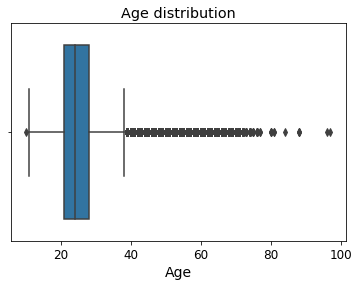

In [443]:
sns.boxplot(df_olympics['Age'])
plt.title('Age distribution')

Text(0.5, 0, 'Sport')

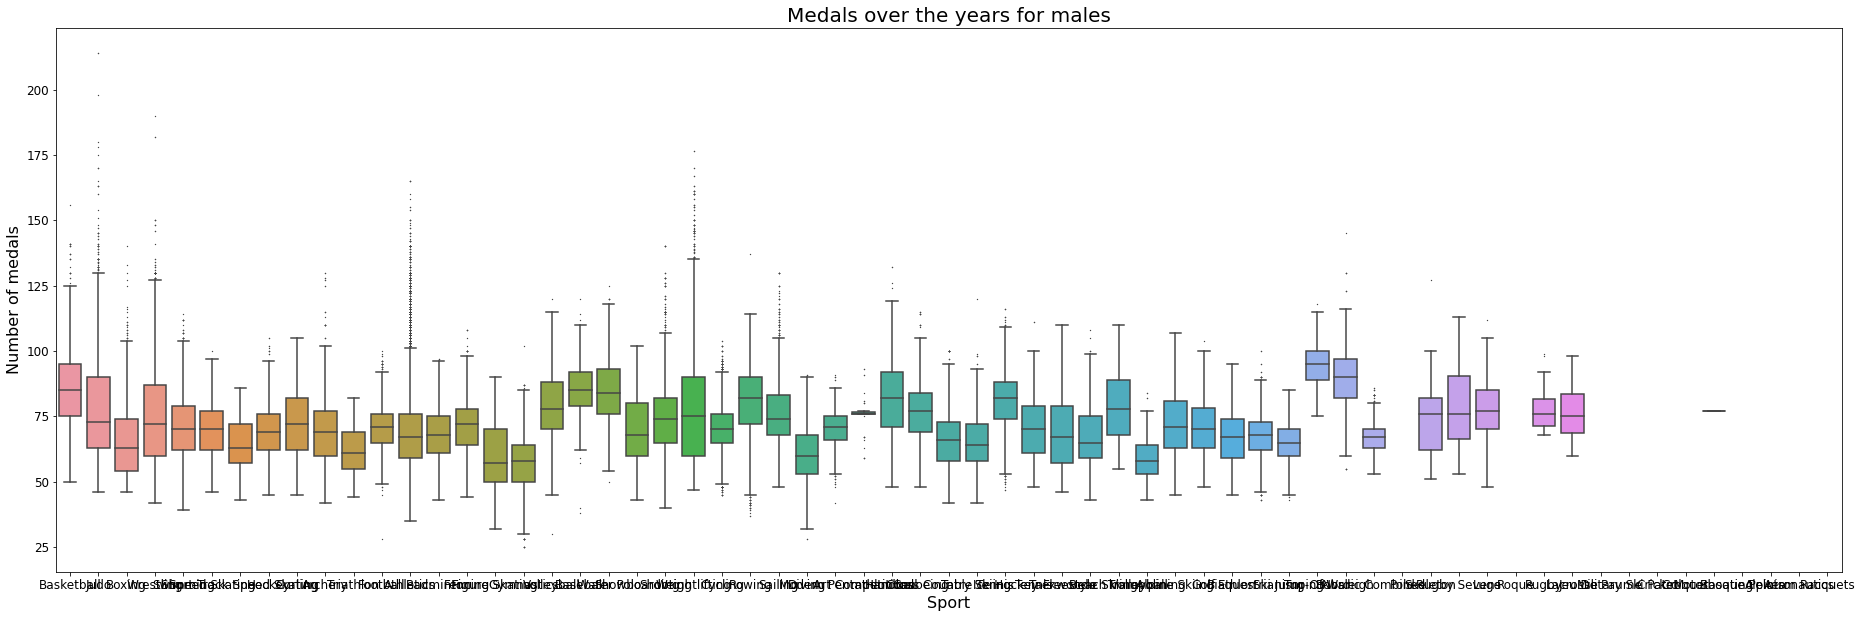

In [444]:
sportsForMales = df_olympics[df_olympics.Sex=='M'].Sport.unique()
fig, ax = plt.subplots(figsize=(32,10))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(sportsForMales)],x='Sport',y='Weight',fliersize=1/2)

plt.title('Male weights per Sports');
ax.set_title('Medals over the years for males' , fontsize=20)
ax.set_ylabel("Number of medals",fontsize=16 )
ax.set_xlabel("Sport",fontsize=16 )

Text(0.5, 0, 'Sport')

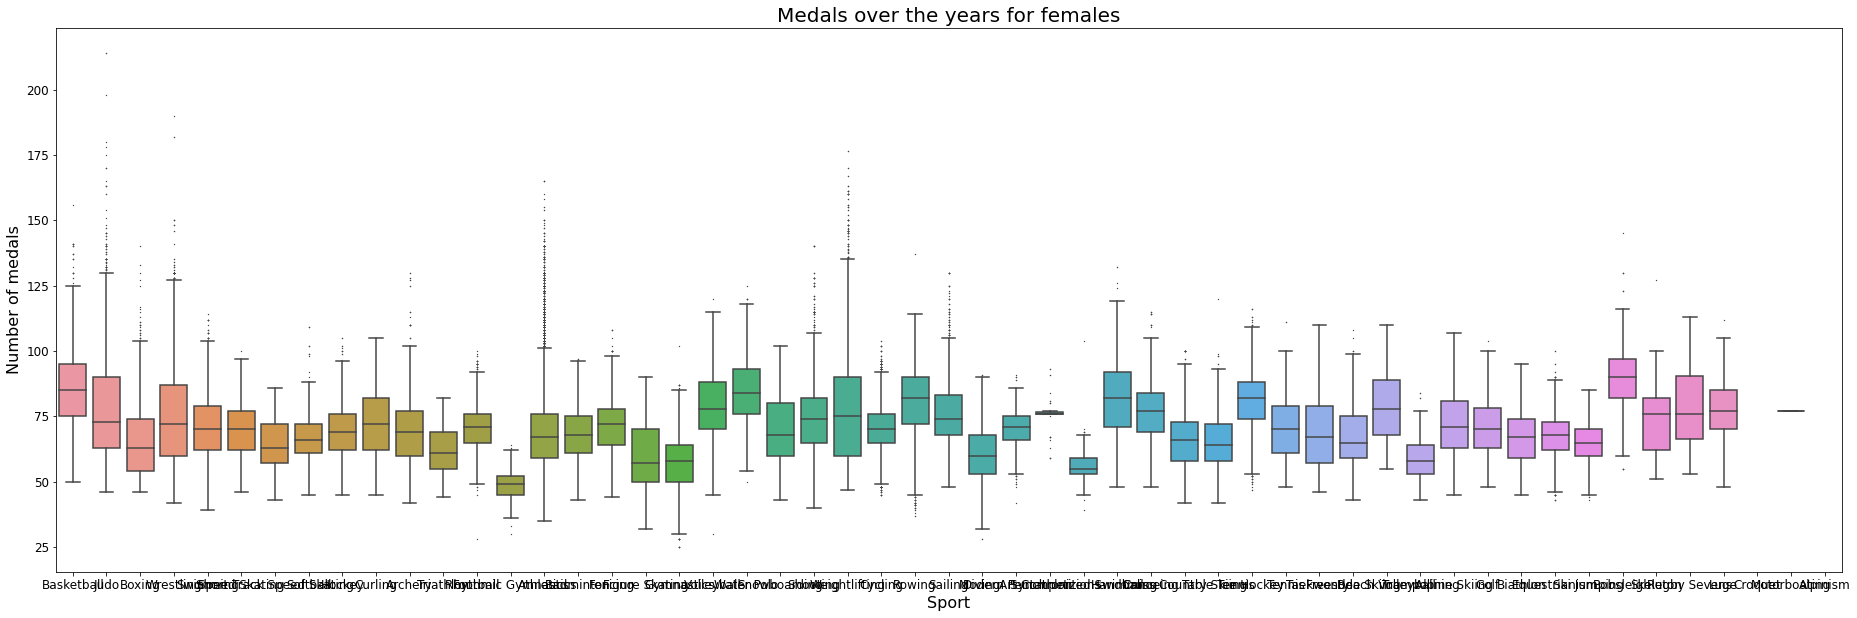

In [445]:
sportsForFemales = df_olympics[df_olympics.Sex=='F'].Sport.unique()
fig, ax = plt.subplots(figsize=(32,10))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(sportsForFemales)],x='Sport',y='Weight',fliersize=1/2)

plt.title('Female weights per Sports');
ax.set_title('Medals over the years for females' , fontsize=20)
ax.set_ylabel("Number of medals",fontsize=16 )
ax.set_xlabel("Sport",fontsize=16 )

In [446]:
df_olympics.groupby(['Team']).count().sort_values(by='ID').head(50)

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
Team,,,,,,,,,,,,,,,,
Bonaparte,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
Greenoaks Dundee,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0
Rambo,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0
Bremen,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0
Brentina,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0
Breslau,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,0
Briar,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0
Ravel,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0
Relampago,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0


Text(0.5, 0.98, 'Countries winning the most number of each medal')

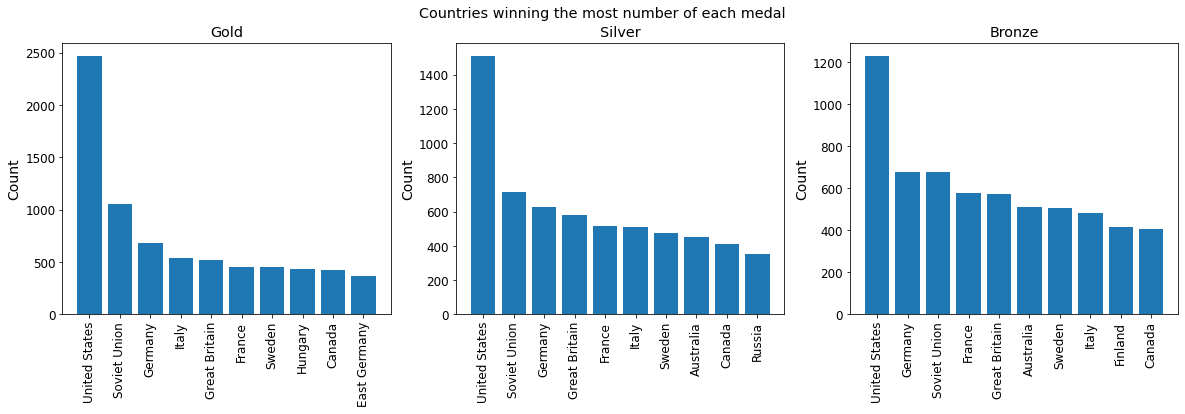

In [447]:
top_country_with_medals_df = df_olympics.groupby(['Medal', 'Team'])['ID'].count()
top_country_with_medals_df
gold_medals_sorted_df = top_country_with_medals_df['Gold'].sort_values(ascending=False)
silver_medals_sorted_df = top_country_with_medals_df['Silver'].sort_values(ascending=False)
bronze_medals_sorted_df = top_country_with_medals_df['Bronze'].sort_values(ascending=False)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1.bar(gold_medals_sorted_df[:10].index, gold_medals_sorted_df[:10])
ax1.set_xticklabels(gold_medals_sorted_df[:10].index, rotation=90);
ax1.set_ylabel('Count')
ax1.set_title('Gold')

ax2.bar(silver_medals_sorted_df[:10].index, silver_medals_sorted_df[:10])
ax2.set_xticklabels(silver_medals_sorted_df[:10].index, rotation=90);
ax2.set_ylabel('Count')
ax2.set_title('Silver')

ax3.bar(bronze_medals_sorted_df[:10].index, bronze_medals_sorted_df[:10])
ax3.set_xticklabels(bronze_medals_sorted_df[:10].index, rotation=90);
ax3.set_ylabel('Count')
ax3.set_title('Bronze')
fig.suptitle('Countries winning the most number of each medal')

In [448]:
athletes_winter_df = df_olympics[df_olympics['Season'] == 'Winter']
athletes_summer_df = df_olympics[df_olympics['Season'] == 'Summer']

print('Winter: ', athletes_winter_df.Sport.unique())
print('Summer: ', athletes_summer_df.Sport.unique())

#Sports that are in winter games only
only_winter_sports = {s for s in athletes_winter_df.Sport if s not in athletes_summer_df.Sport}
print("Sports that are in winter games only: ", only_winter_sports)

#Sports that are in suumer games only
only_summer_sports = {s for s in athletes_summer_df.Sport if s not in athletes_winter_df.Sport}
print("Sports that are in summer games only: ", only_summer_sports)



Winter:  ['Speed Skating' 'Short Track Speed Skating' 'Curling' 'Figure Skating'
 'Snowboarding' 'Cross Country Skiing' 'Ice Hockey' 'Freestyle Skiing'
 'Alpine Skiing' 'Biathlon' 'Ski Jumping' 'Bobsleigh' 'Nordic Combined'
 'Skeleton' 'Luge' 'Military Ski Patrol' 'Alpinism']
Summer:  ['Basketball' 'Judo' 'Boxing' 'Wrestling' 'Swimming' 'Softball' 'Hockey'
 'Archery' 'Triathlon' 'Football' 'Rhythmic Gymnastics' 'Athletics'
 'Badminton' 'Fencing' 'Gymnastics' 'Volleyball' 'Baseball' 'Water Polo'
 'Shooting' 'Weightlifting' 'Cycling' 'Rowing' 'Sailing' 'Diving'
 'Modern Pentathlon' 'Art Competitions' 'Synchronized Swimming' 'Handball'
 'Canoeing' 'Table Tennis' 'Tennis' 'Taekwondo' 'Beach Volleyball'
 'Trampolining' 'Golf' 'Equestrianism' 'Tug-Of-War' 'Polo' 'Rugby Sevens'
 'Ice Hockey' 'Figure Skating' 'Roque' 'Rugby' 'Lacrosse' 'Jeu De Paume'
 'Cricket' 'Croquet' 'Motorboating' 'Basque Pelota' 'Alpinism'
 'Aeronautics' 'Racquets']
Sports that are in winter games only:  {'Biathlon', 'Cu

**Timeline of countries winning medals**


In [449]:
athletes_medals_df = df_olympics.dropna(axis='index', subset=['Medal'])
athletes_medals_df[df_olympics['ID'] == 1017]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
14642,1017,Nathan Ghar-Jun Adrian,M,19.0,198.0,100.0,United States,USA,2008 Summer,2008,Summer,Beijing,Swimming,Swimming Men's 4 x 100 metres Freestyle Relay,Gold,USA,NaN
14643,1017,Nathan Ghar-Jun Adrian,M,23.0,198.0,100.0,United States,USA,2012 Summer,2012,Summer,London,Swimming,Swimming Men's 100 metres Freestyle,Gold,USA,NaN
14644,1017,Nathan Ghar-Jun Adrian,M,23.0,198.0,100.0,United States,USA,2012 Summer,2012,Summer,London,Swimming,Swimming Men's 4 x 100 metres Freestyle Relay,Silver,USA,NaN
14645,1017,Nathan Ghar-Jun Adrian,M,23.0,198.0,100.0,United States,USA,2012 Summer,2012,Summer,London,Swimming,Swimming Men's 4 x 100 metres Medley Relay,Gold,USA,NaN
14646,1017,Nathan Ghar-Jun Adrian,M,27.0,198.0,100.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 50 metres Freestyle,Bronze,USA,NaN
14647,1017,Nathan Ghar-Jun Adrian,M,27.0,198.0,100.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 100 metres Freestyle,Bronze,USA,NaN
14648,1017,Nathan Ghar-Jun Adrian,M,27.0,198.0,100.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 4 x 100 metres Freestyle Relay,Gold,USA,NaN
14649,1017,Nathan Ghar-Jun Adrian,M,27.0,198.0,100.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 4 x 100 metres Medley Relay,Gold,USA,NaN


In [450]:
athletes_medals_df[(athletes_medals_df['NOC'] == 'USA') & (athletes_medals_df['Year'] == 2016)]


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
14630,837,Rachael Alexis Adams,F,26.0,188.0,81.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Volleyball,Volleyball Women's Volleyball,Bronze,USA,NaN
14646,1017,Nathan Ghar-Jun Adrian,M,27.0,198.0,100.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 50 metres Freestyle,Bronze,USA,NaN
14647,1017,Nathan Ghar-Jun Adrian,M,27.0,198.0,100.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 100 metres Freestyle,Bronze,USA,NaN
14648,1017,Nathan Ghar-Jun Adrian,M,27.0,198.0,100.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 4 x 100 metres Freestyle Relay,Gold,USA,NaN
14649,1017,Nathan Ghar-Jun Adrian,M,27.0,198.0,100.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 4 x 100 metres Medley Relay,Gold,USA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32531,129913,Lindsay Marie Whalen,F,34.0,175.0,72.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Basketball,Basketball Women's Basketball,Gold,USA,NaN
32803,130696,Venus Ebony Starr Williams,F,36.0,185.0,75.0,United States-1,USA,2016 Summer,2016,Summer,Rio de Janeiro,Tennis,Tennis Mixed Doubles,Silver,USA,NaN
33087,131614,Kelsi Worrell,F,22.0,180.0,75.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Women's 4 x 100 metres Medley Relay,Gold,USA,NaN
33103,131654,Dagmara Wozniak (Woniak-),F,28.0,173.0,81.0,United States,USA,2016 Summer,2016,Summer,Rio de Janeiro,Fencing,"Fencing Women's Sabre, Team",Bronze,USA,NaN


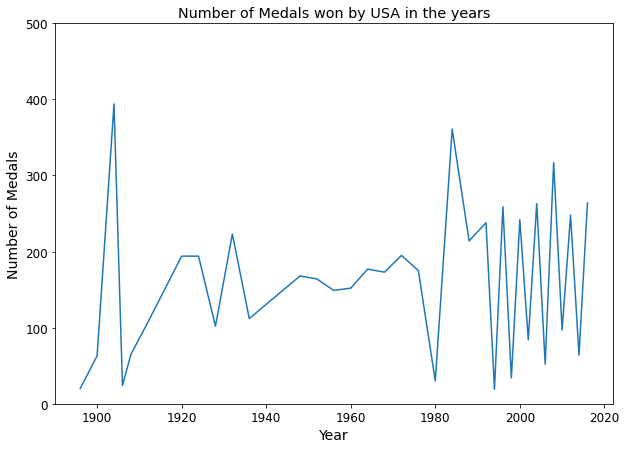

In [451]:
# United States
medals_per_country_across_years = athletes_medals_df.groupby(['NOC','Year'])['Medal'].count()
usa_medas_per_year = medals_per_country_across_years['USA']

plt.figure(figsize=(10,7))
plt.plot(usa_medas_per_year,)
plt.title('Number of Medals won by USA in the years')
plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.ylim(0,500);

# **OUTLIERS & EXTREME VALUES**

We found that there is no age restrictions for joining the olympics, and the age range was not discontinuous (no explicit outlier), as well as there were a number of athletes above 60 who won medals.

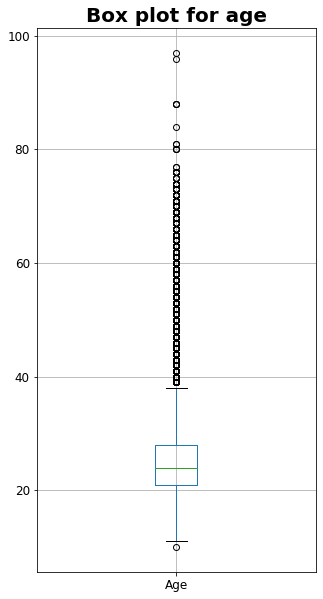

In [452]:
fig, ax = plt.subplots(1, figsize = (5,10))
df_olympics.boxplot(ax=ax, column=['Age'])
plt.title('Box plot for age', fontsize = 20, fontweight="bold")
plt.show()

# df_olympics.boxplot(column =['Age'], grid = False, figsize=(10,10))

In [453]:
above60 = df_olympics[df_olympics['Age']>65 ]
above60WithMedals = above60[above60['Medal'] !='no medal' ]
above60WithMedals.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
5539,18252,Anne Marie Carl-Nielsen (Brodersen-),F,69.0,NaN,NaN,Denmark,DEN,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Sculpturing, Unknown Event",NaN,Denmark,NaN
5540,18252,Anne Marie Carl-Nielsen (Brodersen-),F,69.0,NaN,NaN,Denmark,DEN,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Sculpturing, Unknown Event",NaN,Denmark,NaN
5541,18252,Anne Marie Carl-Nielsen (Brodersen-),F,69.0,NaN,NaN,Denmark,DEN,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Sculpturing, Unknown Event",NaN,Denmark,NaN
5542,18252,Anne Marie Carl-Nielsen (Brodersen-),F,69.0,NaN,NaN,Denmark,DEN,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Sculpturing, Unknown Event",NaN,Denmark,NaN
5543,18252,Anne Marie Carl-Nielsen (Brodersen-),F,69.0,NaN,NaN,Denmark,DEN,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Sculpturing, Unknown Event",NaN,Denmark,NaN


#### **Handling AGE outliers**

Handled with two functions, where the first function takes the dataframe for a single sport and calculates the right and left whiskers as well as the mean of the entries that are not considered outliers. Second function replaces the outliers of the age column for each sport with the mean of the age of participants without the outliers. In other words, replacing age outliers with the mean per sport.

**BEFORE handling age outliers**

In [454]:
df_olympics.describe()

,ID,Age,Height,Weight,Year
count,270767.000000,261305.000000,210684.000000,207982.000000,270767.000000
mean,68229.276832,25.559783,175.344250,70.709523,1978.362297
std,39017.998824,6.392501,10.519556,14.350094,29.884637
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34630.500000,21.000000,168.000000,60.000000,1960.000000
50%,68187.000000,24.000000,175.000000,70.000000,1988.000000
75%,102065.500000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


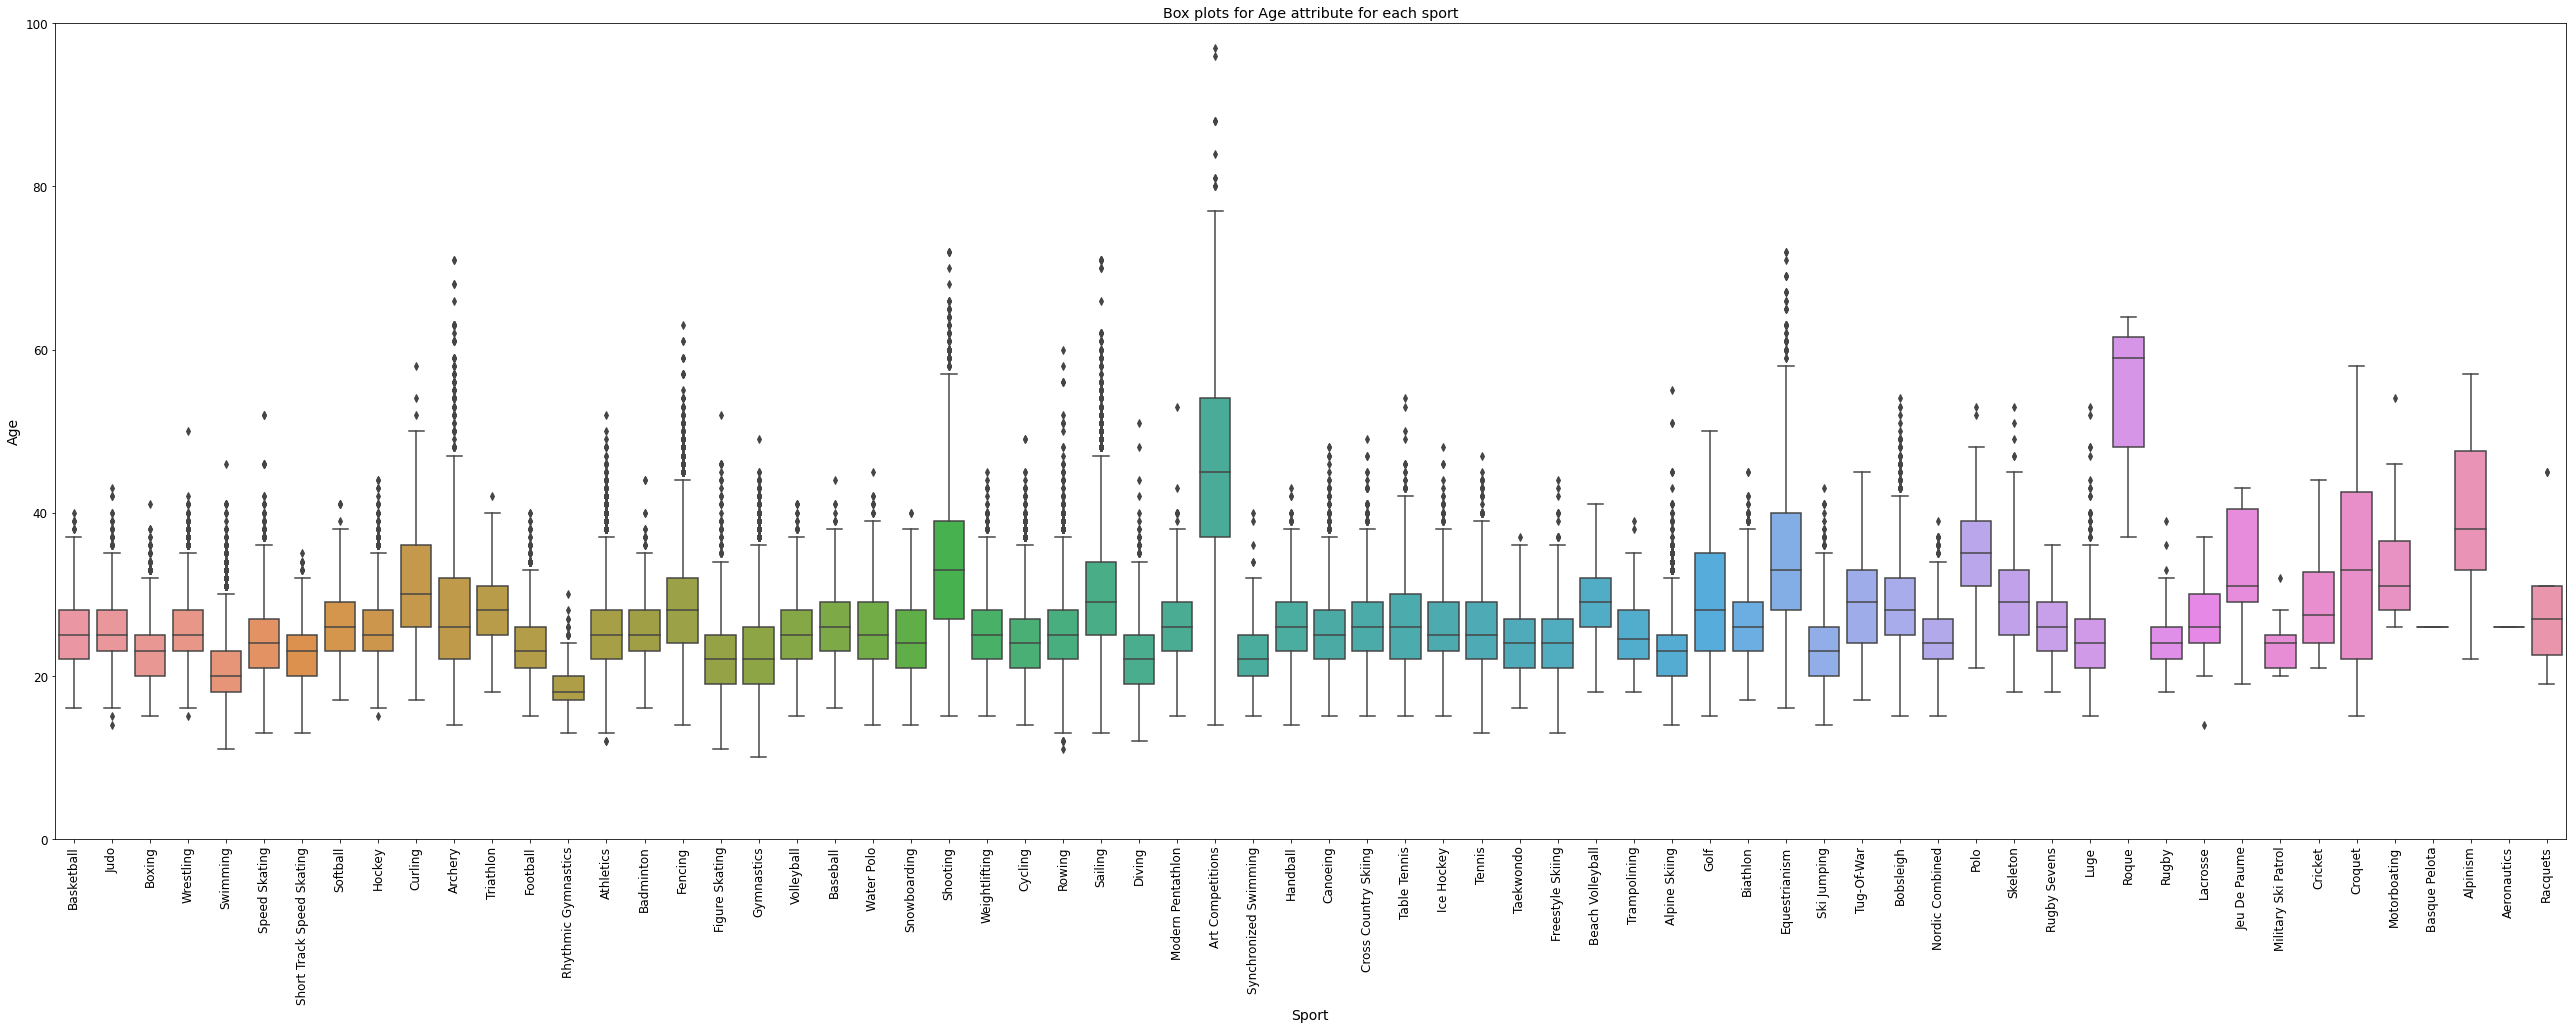

In [455]:
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Age')

averageAge = round(df_olympics['Age'].mean())
plt.ylim(0, 100)
plt.xticks(rotation=90)
plt.title('Box plots for Age attribute for each sport');

In [456]:
def get_age_mean_without_outliers(sport_df):
    Q1 = sport_df.Age.quantile(0.25)
    Q2 = sport_df.Age.quantile(0.5)
    Q3 = sport_df.Age.quantile(0.75)
    IQR = Q3 - Q1
    left_whisker = Q1 - 1.5 * IQR
    right_whisker = Q3 + 1.5 * IQR
    sport_inliers = sport_df[(sport_df.Age <= right_whisker) & (sport_df.Age >= left_whisker)]
    mean = sport_inliers.Age.mean()

    return {
        'right_whisker': right_whisker,
        'left_whisker' : left_whisker,
        'mean' : int(mean)
    }

In [457]:
def handle_age_outliers(athletes_df):
    athletes_df_no_age_outliers = pd.DataFrame()
    n_outliers = 0
    olympics_sports = athletes_df.Sport.unique()
    for s in olympics_sports:
        sport_df = athletes_df[athletes_df.Sport == s]
        outliers_dict = get_age_mean_without_outliers(sport_df=sport_df)

        outliers_age_list = np.array(sport_df.loc[(sport_df.Age < outliers_dict['left_whisker']) | (sport_df.Age > outliers_dict['right_whisker']), 'Age'])
        n_outliers+= len(outliers_age_list)
        sport_df.Age.replace(outliers_age_list, outliers_dict['mean'], inplace=True)
        athletes_df_no_age_outliers = athletes_df_no_age_outliers.append(sport_df)
    return athletes_df_no_age_outliers

In [458]:
df_olympics = handle_age_outliers(df_olympics)

**AFTER handling age outliers**

In [459]:
df_olympics.describe()

,ID,Age,Height,Weight,Year
count,270767.000000,261305.000000,210684.000000,207982.000000,270767.000000
mean,68229.276832,25.360579,175.344250,70.709523,1978.362297
std,39017.998824,6.088544,10.519556,14.350094,29.884637
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34630.500000,21.000000,168.000000,60.000000,1960.000000
50%,68187.000000,24.000000,175.000000,70.000000,1988.000000
75%,102065.500000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,77.000000,226.000000,214.000000,2016.000000


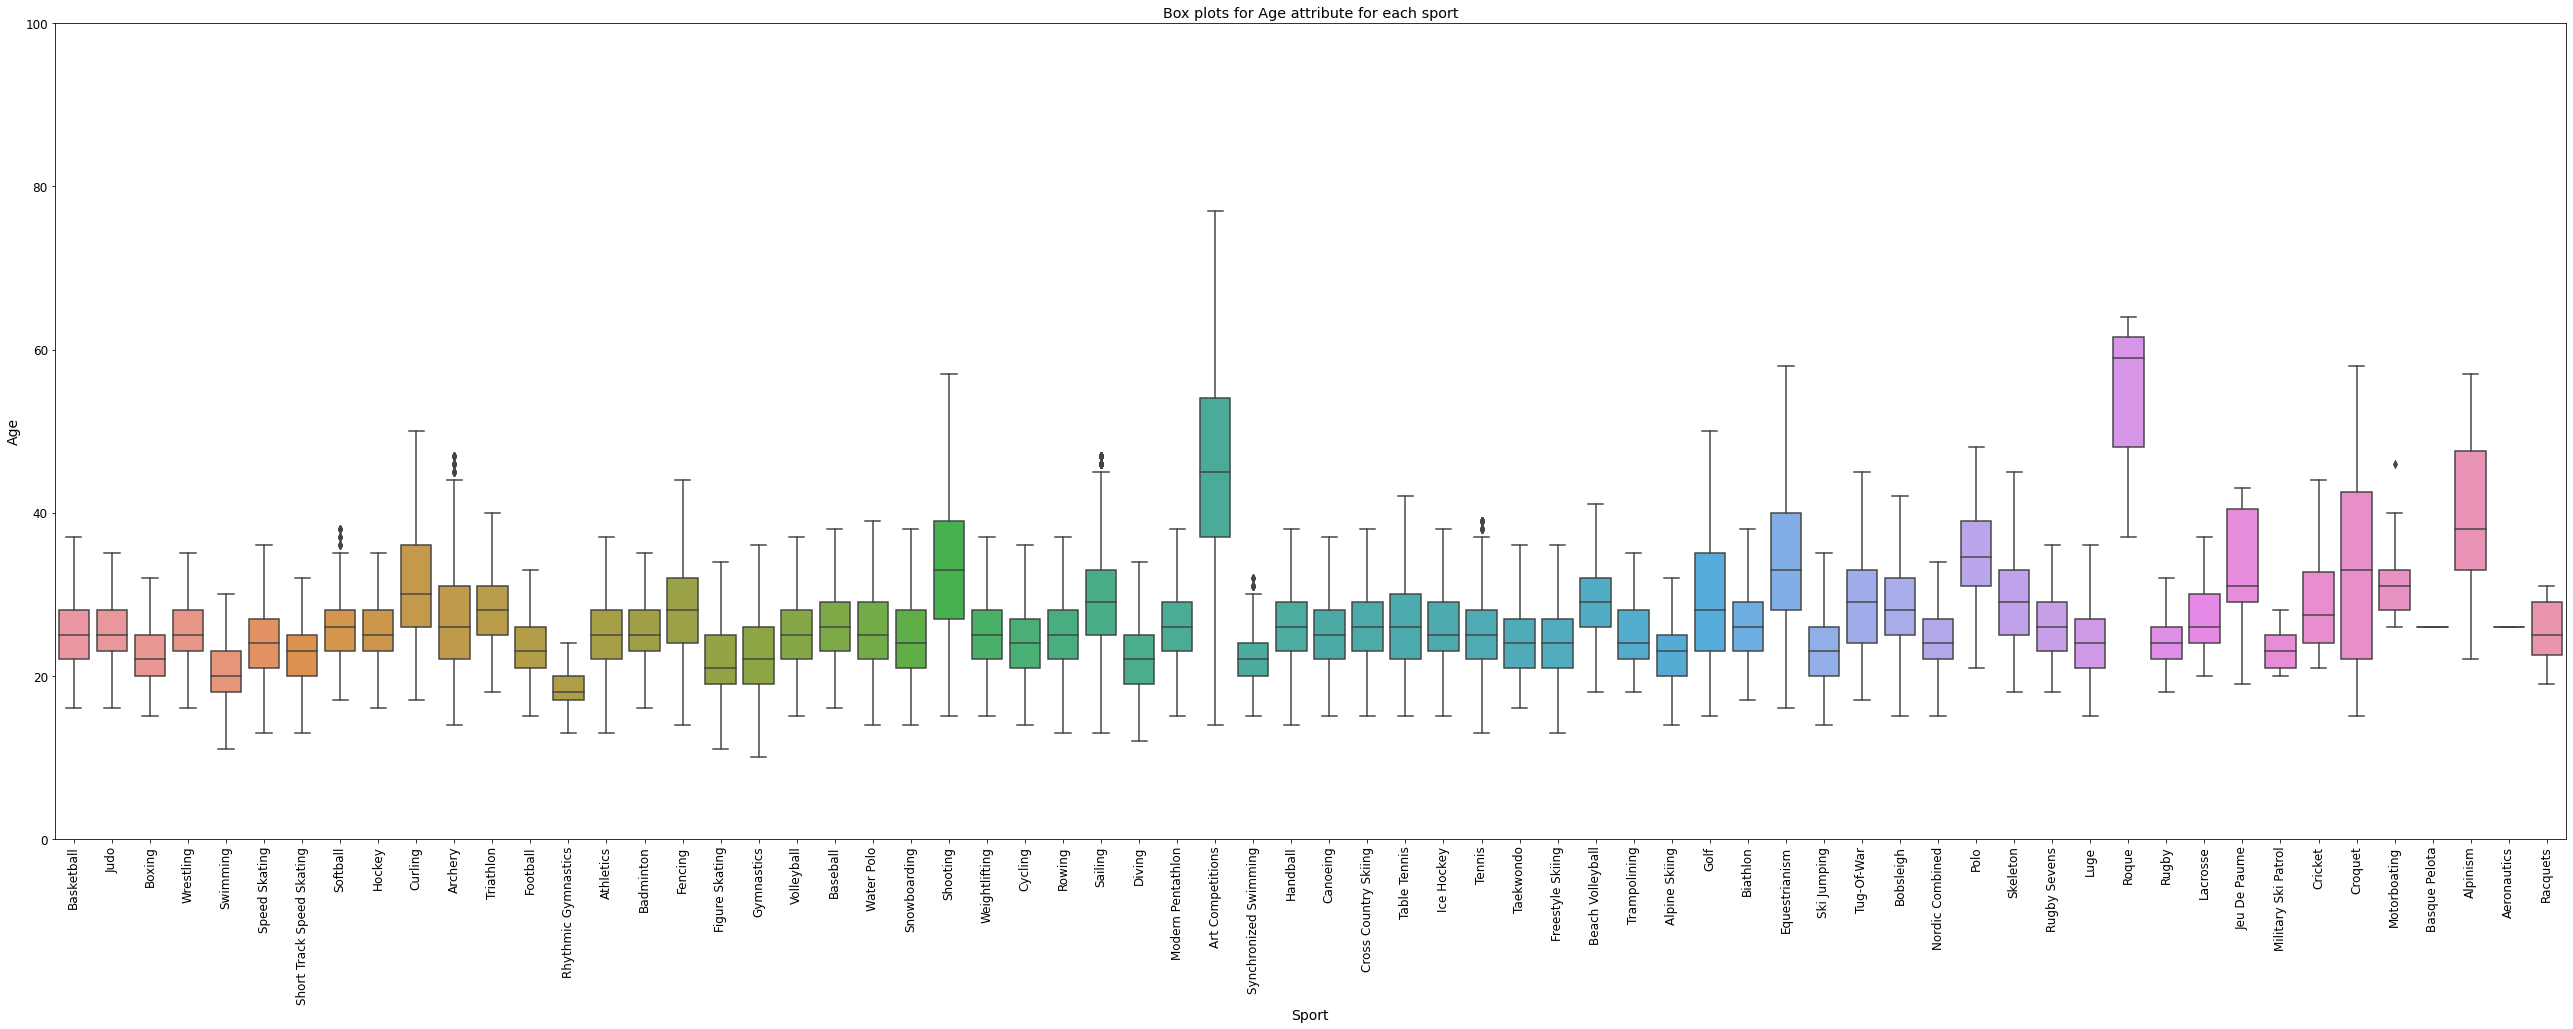

In [460]:
# AFTER handling age outliers
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Age')

averageAge = round(df_olympics['Age'].mean())

plt.ylim(0, 100)
plt.xticks(rotation=90)
plt.title('Box plots for Age attribute for each sport');

#### **Handling WEIGHT outliers**

**BEFORE handling weight outliers**

In [461]:
df_olympics.describe()

,ID,Age,Height,Weight,Year
count,270767.000000,261305.000000,210684.000000,207982.000000,270767.000000
mean,68229.276832,25.360579,175.344250,70.709523,1978.362297
std,39017.998824,6.088544,10.519556,14.350094,29.884637
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34630.500000,21.000000,168.000000,60.000000,1960.000000
50%,68187.000000,24.000000,175.000000,70.000000,1988.000000
75%,102065.500000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,77.000000,226.000000,214.000000,2016.000000


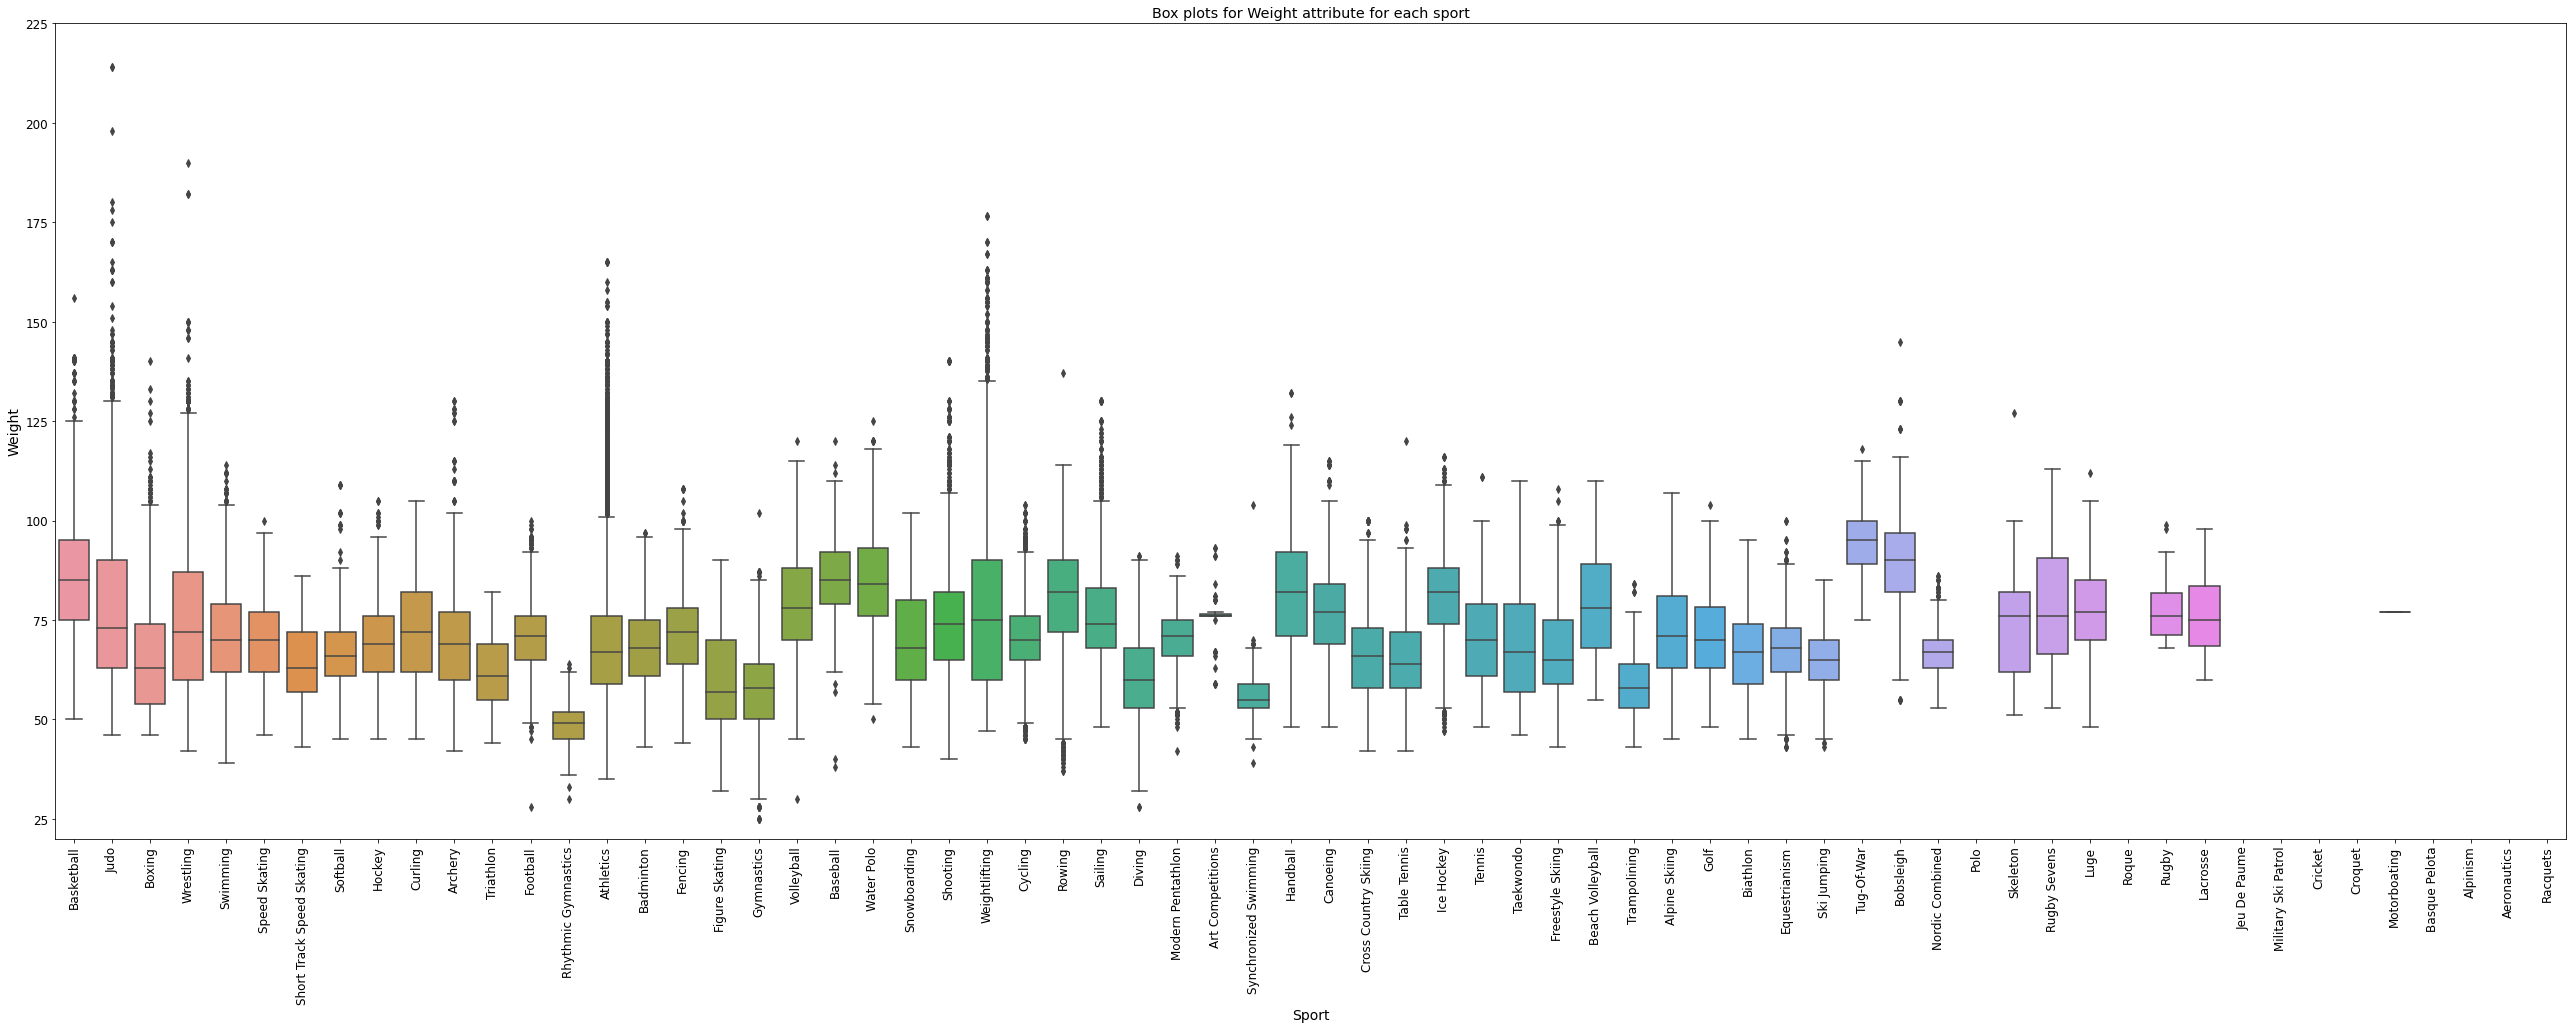

In [462]:
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Weight')

averageAge = round(df_olympics['Weight'].mean())

plt.ylim(20, 225)
plt.xticks(rotation=90)
plt.title('Box plots for Weight attribute for each sport');

In [463]:
def outliers_percentage_zscore(column,df):
    df_olympics_non_null = df[df_olympics[column].notna()]
    z=stats.zscore(df_olympics_non_null[column])
    z
    filtered=df_olympics_non_null[(z<3)&(z>-3)]

    print('Shape of df after dropping nulls',df_olympics_non_null.shape)
    print('Shape of non-outliers',filtered.shape)
    print((len(df_olympics_non_null)-len(filtered))*100/len(df))
    return len(df_olympics_non_null)-len(filtered)

We handled outliers first separating by gender for each event, but first by filtering the events that have no weights first then looping on the events, and using inter-quartile range to calculate the average of the values which aren't outliers, then assigning this value to the outliers. In other words, this means that w replaced outliers with the mean per event and gender. We choose weight specifically as some events had defined weight ranges for participants.

In [464]:
Events = df_olympics["Event"].unique()
def RemovingWeightOutliersPerGender(gender):
    eventsWithEmptyWeight = np.array([])
    for event in Events:
        temp = df_olympics[(df_olympics.Sex==gender) & (df_olympics.Event==event)]
        if temp.shape[0] == temp['Weight'].isna().sum():
            eventsWithEmptyWeight = np.append(eventsWithEmptyWeight, [event]) 
    validEvents = df_olympics['Event'].unique()
    validEvents = np.setdiff1d(validEvents, eventsWithEmptyWeight)
    sum = 0
    sum1 = 0 
    for event in validEvents:
        Q1 = df_olympics["Weight"].quantile(0.25)
        Q3 = df_olympics["Weight"].quantile(0.75)
        IQR = Q3 - Q1
        cut_off = IQR * 1.5
        lower = Q1 - cut_off
        upper =  Q3 + cut_off
        df1 = df_olympics[(df_olympics["Weight"]> upper) & (df_olympics.Sex==gender)& (df_olympics.Event==event)]
        df2 = df_olympics[(df_olympics["Weight"] < lower) & (df_olympics.Sex==gender)& (df_olympics.Event==event)]
        df = df_olympics[(df_olympics["Weight"] >= lower) & (df_olympics["Weight"] <= upper) & (df_olympics.Sex==gender)& (df_olympics.Event==event)]
        mean = df["Weight"].mean()
        df_olympics["Weight"].mask(((df_olympics["Weight"] < lower) | (df_olympics["Weight"] > upper)) & (df_olympics.Sex==gender)& (df_olympics.Event==event), mean, inplace = True)

In [465]:
RemovingWeightOutliersPerGender('F')
RemovingWeightOutliersPerGender('M')

**AFTER handling weight outliers**

In [466]:
df_olympics.describe()

,ID,Age,Height,Weight,Year
count,270767.000000,261305.000000,210684.000000,207980.000000,270767.000000
mean,68229.276832,25.360579,175.344250,70.310558,1978.362297
std,39017.998824,6.088544,10.519556,13.201366,29.884637
min,1.000000,10.000000,127.000000,32.000000,1896.000000
25%,34630.500000,21.000000,168.000000,60.000000,1960.000000
50%,68187.000000,24.000000,175.000000,70.000000,1988.000000
75%,102065.500000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,77.000000,226.000000,107.500000,2016.000000


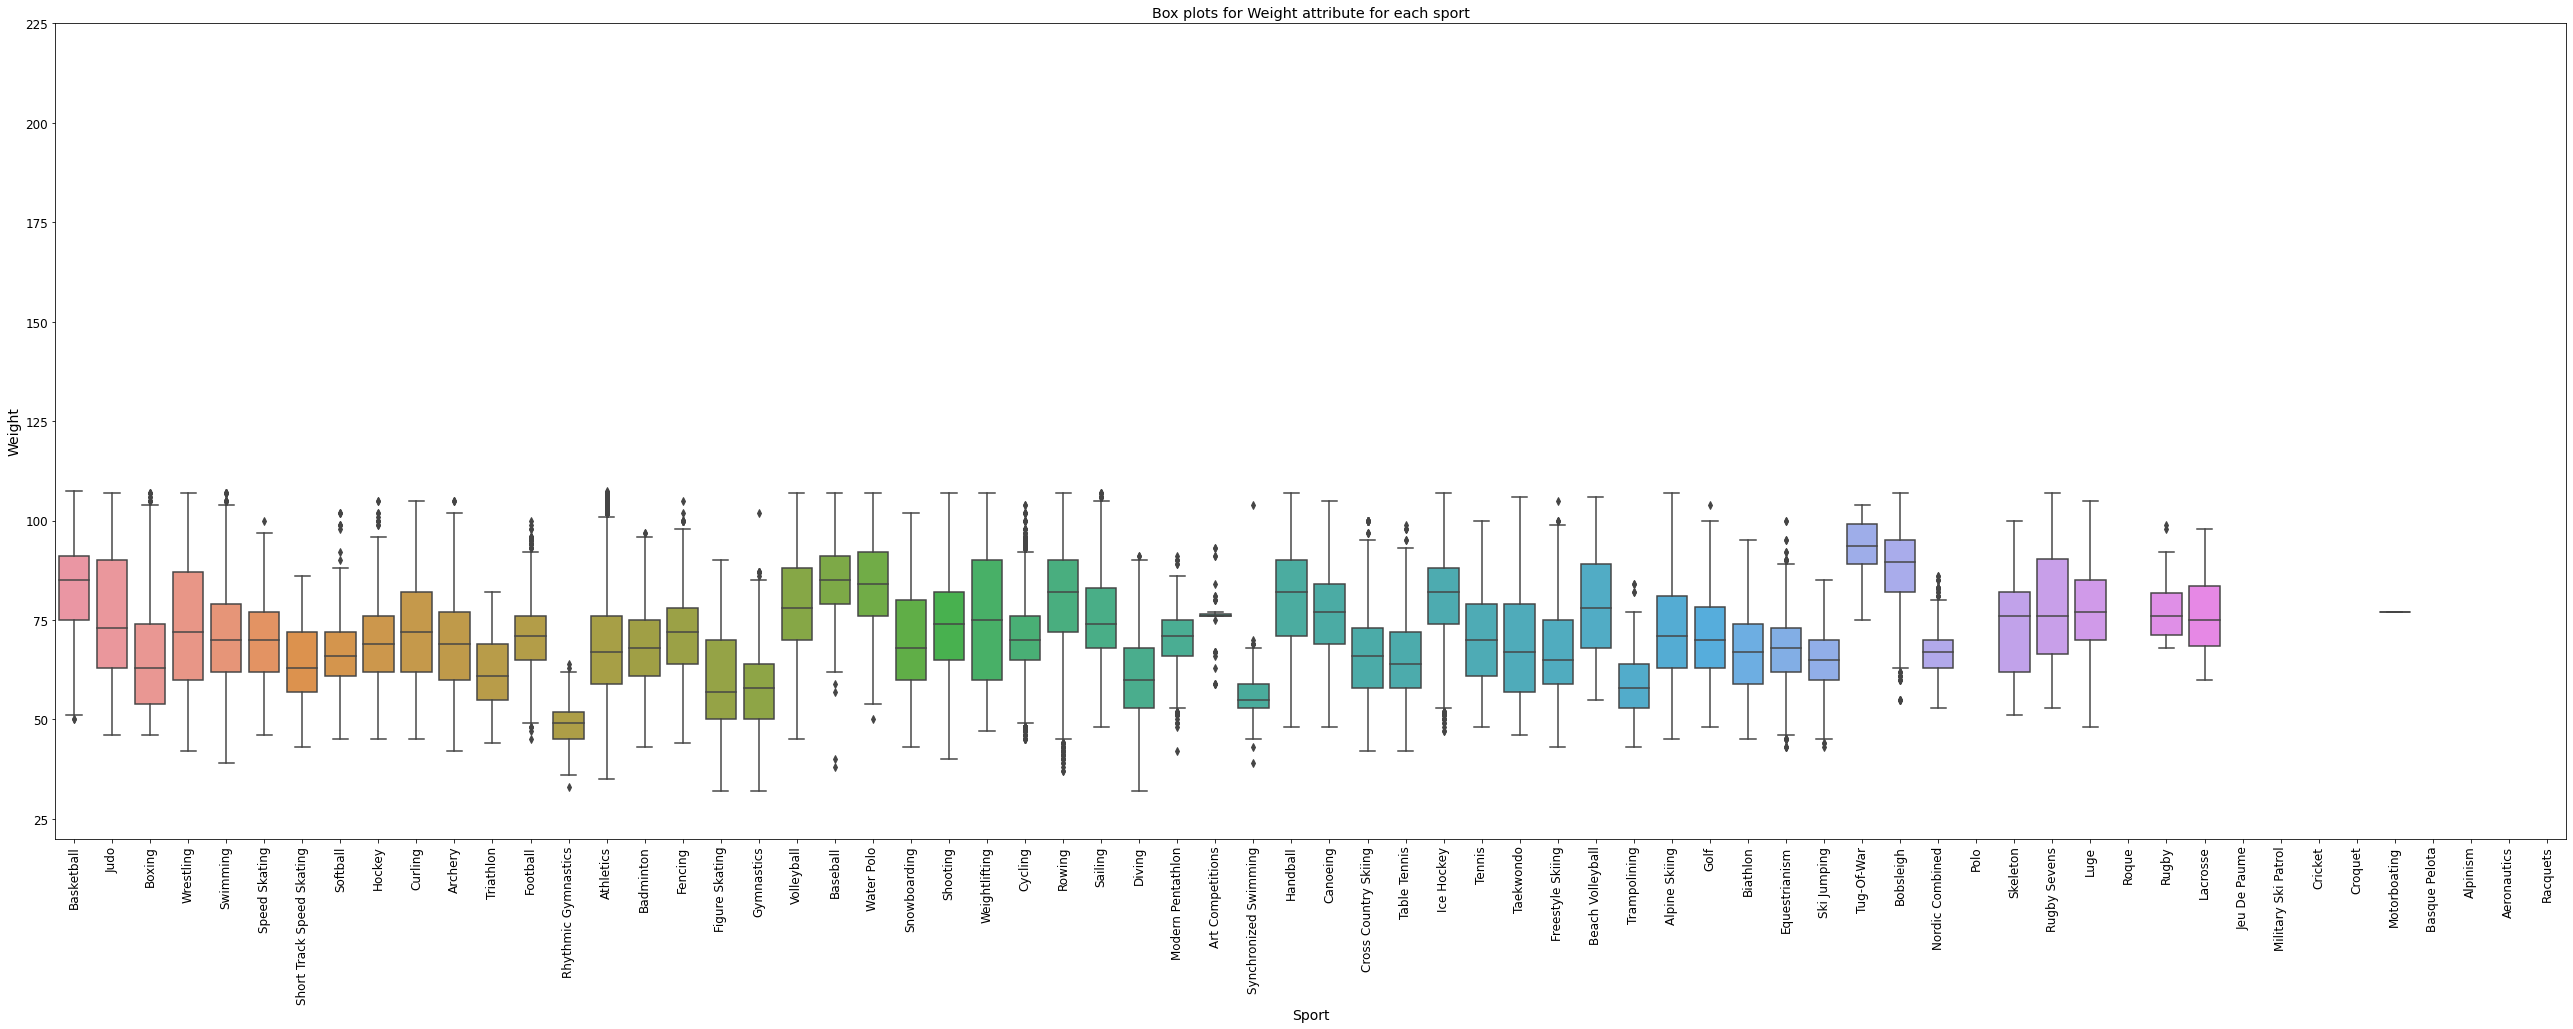

In [467]:
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Weight')

averageAge = round(df_olympics['Weight'].mean())

plt.ylim(20, 225)
plt.xticks(rotation=90)
plt.title('Box plots for Weight attribute for each sport');

#### **Handling HEIGHT outliers**

**BEFORE handling height outliers**

In [469]:
df_olympics.describe()

,ID,Age,Height,Weight,Year
count,270767.000000,261305.000000,210684.000000,207980.000000,270767.000000
mean,68229.276832,25.360579,175.344250,70.310558,1978.362297
std,39017.998824,6.088544,10.519556,13.201366,29.884637
min,1.000000,10.000000,127.000000,32.000000,1896.000000
25%,34630.500000,21.000000,168.000000,60.000000,1960.000000
50%,68187.000000,24.000000,175.000000,70.000000,1988.000000
75%,102065.500000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,77.000000,226.000000,107.500000,2016.000000


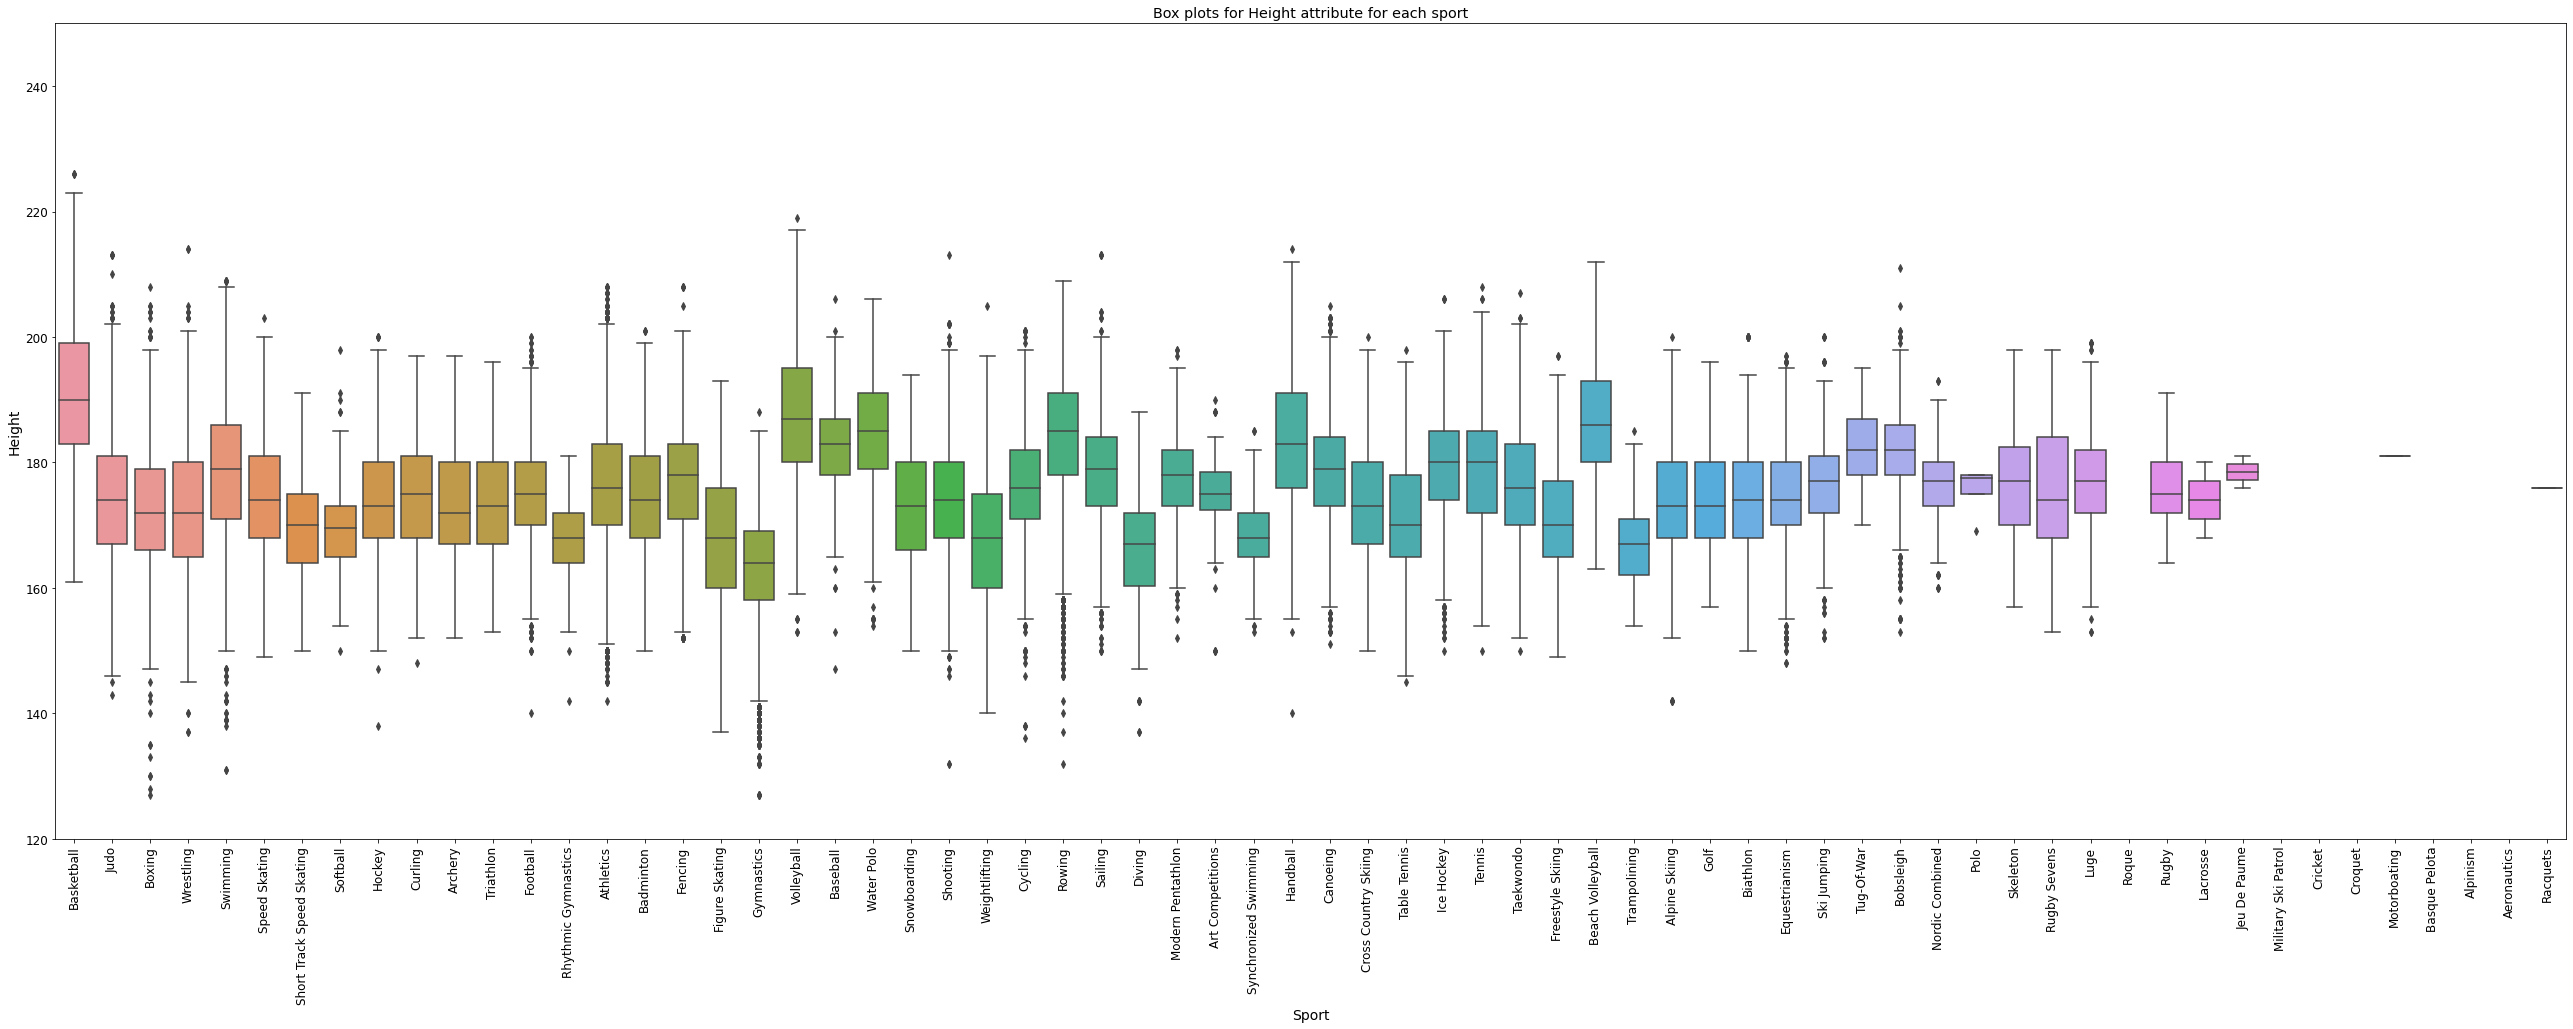

In [470]:
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Height')

averageAge = round(df_olympics['Height'].mean())
plt.ylim(120, 250)
plt.xticks(rotation=90)
plt.title('Box plots for Height attribute for each sport');

 Similar to the weight, we handled outliers first separating by gender for each sport, but first by filtering the events that have no weights first then looping on the sports, and using inter-quartile range to calculate the average of the values which aren't outliers, then assigning this value to the outliers. In other words, this means that w replaced outliers with the mean per sport and gender.

In [471]:
Sports = df_olympics["Sport"].unique()
def RemovingHeightOutliersPerGender(gender):
    sportsWithEmptyHeight = np.array([])
    for sport in Sports:
        temp = df_olympics[(df_olympics.Sex==gender) & (df_olympics.Sport==sport)]
        if temp.shape[0] == temp['Height'].isna().sum():
            sportsWithEmptyHeight = np.append(sportsWithEmptyHeight, [sport]) 
    validSports = df_olympics['Sport'].unique()
    validSports = np.setdiff1d(validSports, sportsWithEmptyHeight)
    sum = 0
    sum1 = 0 
    for sport in validSports:
        Q1 = df_olympics["Height"].quantile(0.25)
        Q3 = df_olympics["Height"].quantile(0.75)
        IQR = Q3 - Q1
        cut_off = IQR * 1.5
        lower = Q1 - cut_off
        upper =  Q3 + cut_off
        df1 = df_olympics[(df_olympics["Height"]> upper) & (df_olympics.Sex==gender)& (df_olympics.Sport==sport)]
        df2 = df_olympics[(df_olympics["Height"] < lower) & (df_olympics.Sex==gender)& (df_olympics.Sport==sport)]
        df = df_olympics[(df_olympics["Height"] >= lower) & (df_olympics["Height"] <= upper) & (df_olympics.Sex==gender)& (df_olympics.Sport==sport)]
        mean = df["Height"].mean()
        df_olympics["Height"].mask(((df_olympics["Height"] < lower) | (df_olympics["Height"] > upper)) & (df_olympics.Sex==gender)& (df_olympics.Sport==sport), mean, inplace = True)


In [472]:
RemovingHeightOutliersPerGender('F')
RemovingHeightOutliersPerGender('M')

**AFTER handling HEIGHT outliers**

In [473]:
df_olympics.describe()

,ID,Age,Height,Weight,Year
count,270767.000000,261305.000000,210684.000000,207980.000000,270767.000000
mean,68229.276832,25.360579,175.344270,70.310558,1978.362297
std,39017.998824,6.088544,10.242708,13.201366,29.884637
min,1.000000,10.000000,146.000000,32.000000,1896.000000
25%,34630.500000,21.000000,168.000000,60.000000,1960.000000
50%,68187.000000,24.000000,175.000000,70.000000,1988.000000
75%,102065.500000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,77.000000,205.000000,107.500000,2016.000000


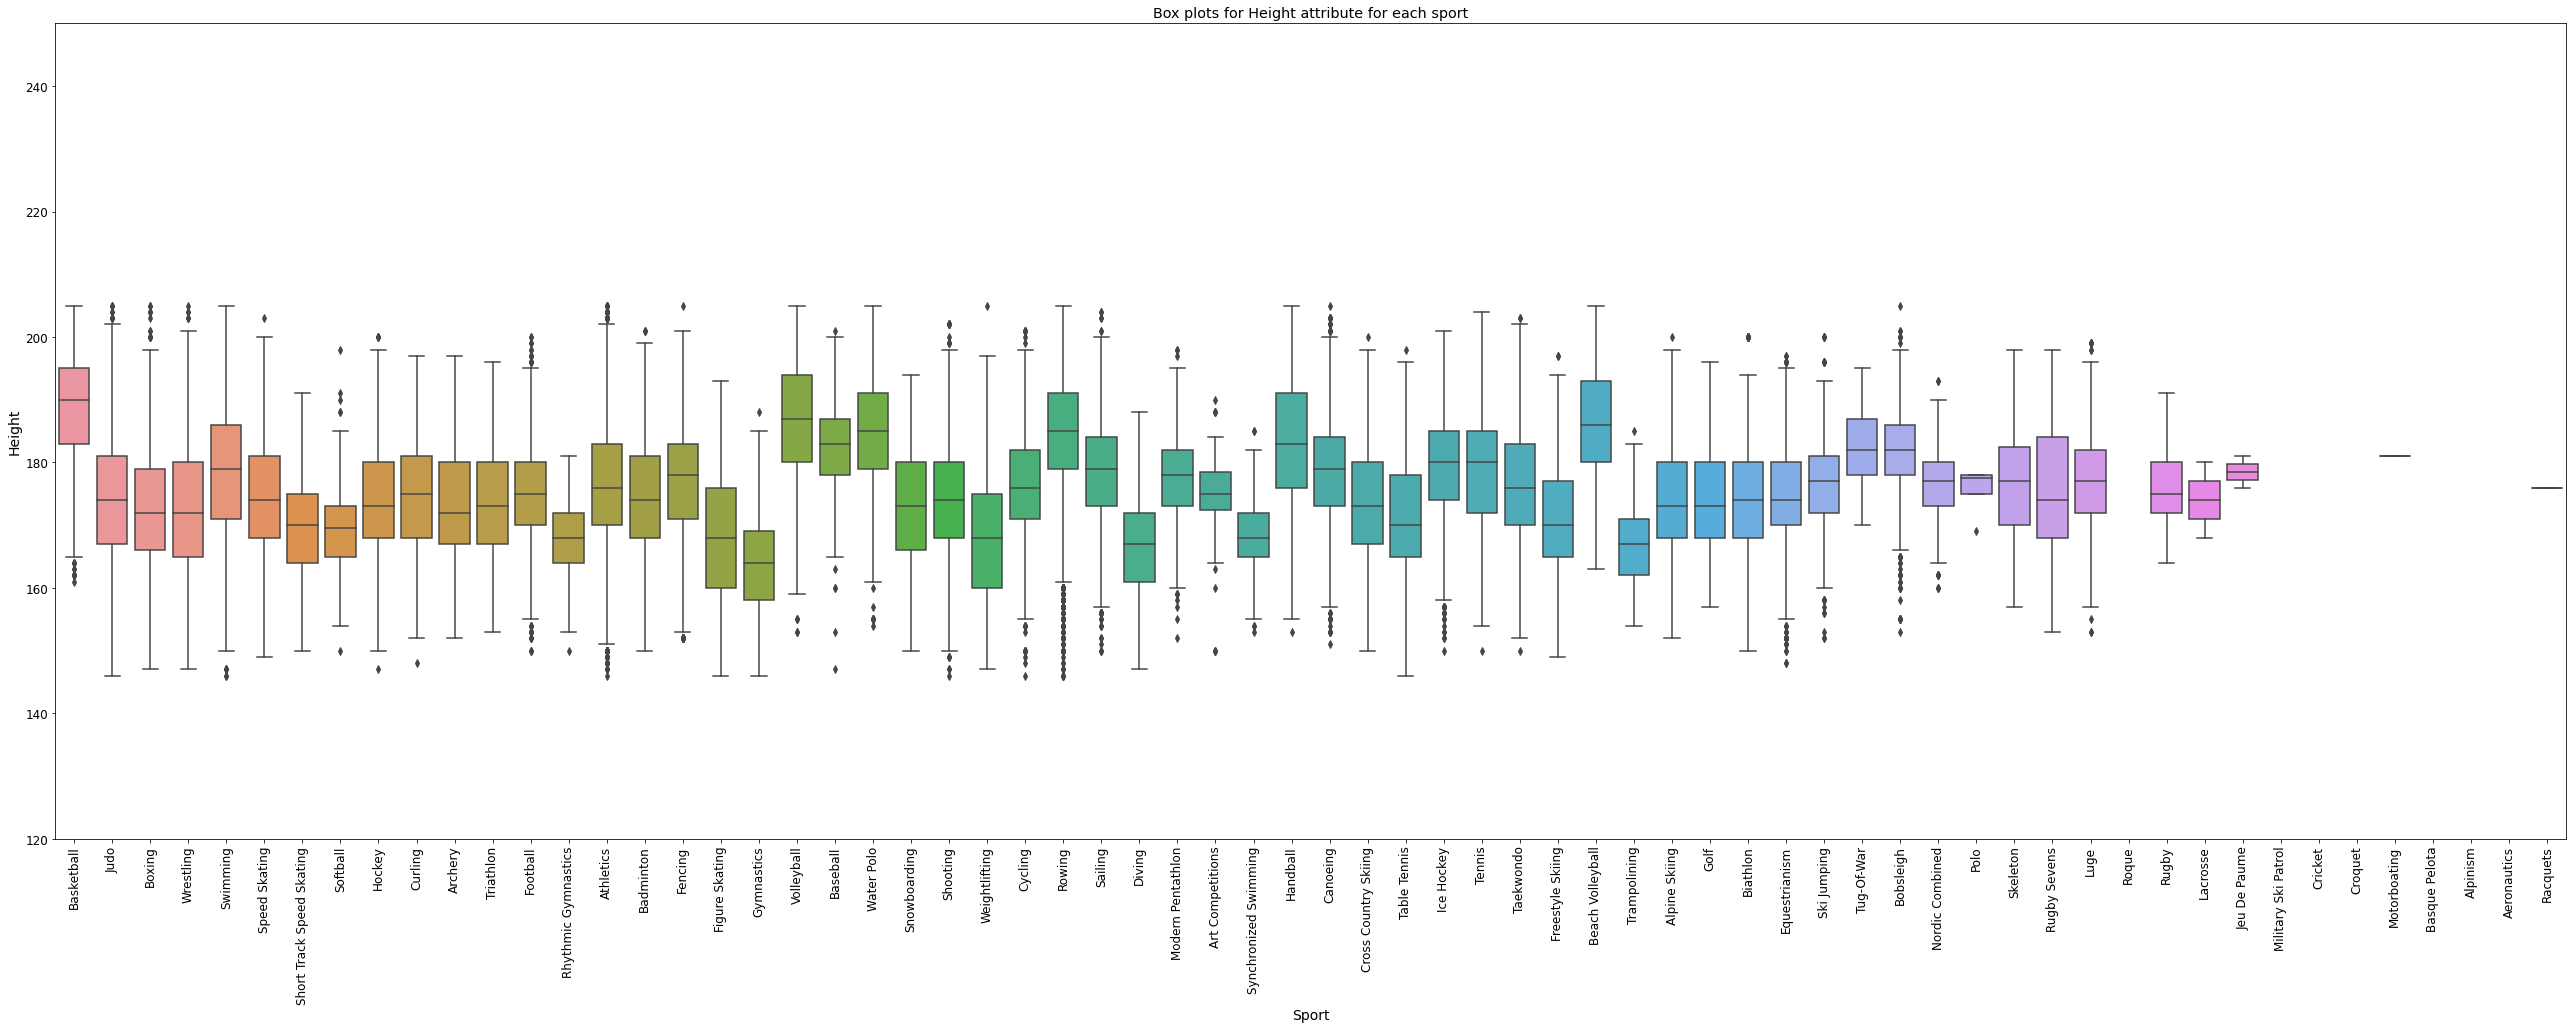

In [474]:
olympics_sports = df_olympics.Sport.unique()
olympics_sports
plt.figure(figsize=(45,15))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(olympics_sports)],x='Sport',y='Height')

averageAge = round(df_olympics['Height'].mean())
plt.ylim(120, 250)
plt.xticks(rotation=90)
plt.title('Box plots for Height attribute for each sport');

# **MISSING VALUES**

Number of missing values per each attribute

In [475]:
# unifying missing values and calculating number of missing values per each row 
df_olympics.replace('NA', np.nan, inplace=True)
df_olympics.replace('Missing', np.nan, inplace=True)

df_olympics.isna().sum()

ID             0
Name           0
Sex            0
Age         9462
Height     60083
Weight     62787
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     230993
region        21
notes     265728
dtype: int64

Dropping duplicate rows 


In [476]:
#Found 1385 duplicated items
duplicateData = df_olympics[df_olympics.duplicated(keep='last')].sort_values(by=['Name'], ascending=True)
duplicateIndexes = duplicateData.index
df_olympics = df_olympics.drop(duplicateIndexes)

In [477]:
# number of rows with Age, Height, Weight together are NaN --> 3%
df_nulls = df_olympics[df_olympics['Age'].isna() & df_olympics['Height'].isna() & df_olympics['Weight'].isna()]
len(df_nulls)

8260

The distribution of the height and weight per gender, to find what is the best way for filling missing values in height and weight attributes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4bc462db90>,
      dtype=object)

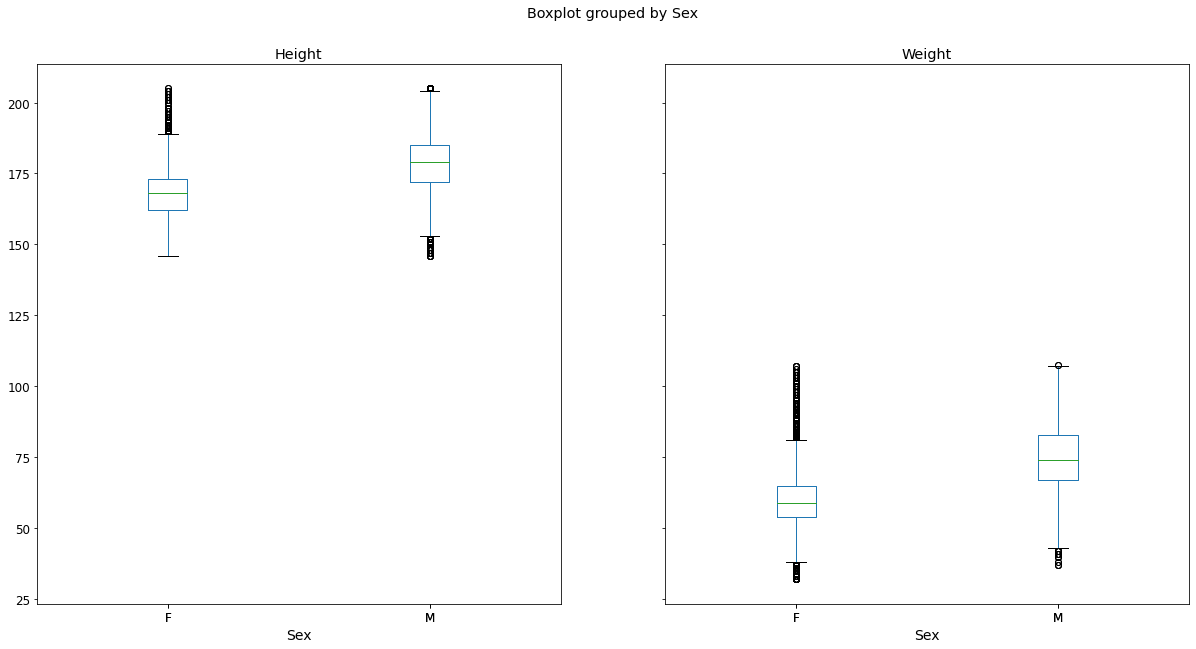

In [478]:
df_olympics.boxplot(by ='Sex', column =['Height', 'Weight'], grid = False, figsize=(20,10))

Remove column notes as it is not needed and full of NANs


In [479]:
df_olympics.drop(['notes'], axis=1, inplace=True)

Figured out that three NOC had no corresponding regions

In [480]:
NOCwithNoRegion = df_olympics[df_olympics['region'].isnull()]
NOCwithNoRegion['NOC'].unique()

# ROT --> Refugee Olympic Team
# UNK -->
# TUV --> Tuvalu

# len(NOCwithNoRegion[NOCwithNoRegion['NOC'] == 'UNK'])

array(['ROT', 'TUV', 'UNK'], dtype=object)

**Handling missing Regions values**
\
Regions were filled according to their corresponding NOC and the unfigured or unknown regions were dropped --> 2 rows only so will not affect our data



In [481]:
# df_olympics['Age'] = df_olympics['Age'].astype(np.float64)

df_olympics['region'].loc[(df_olympics['NOC'] == 'ROT')] = 'Refugee Olympic Team'
df_olympics['region'].loc[(df_olympics['NOC'] == 'TUV')] = 'Tuvalu'

df_olympics.dropna(axis='index', subset=['region'], inplace=True)

**Handling missing age values**
\
We imputed missing age values by the mean value per sport

In [482]:
# Filling missing values 

In [483]:
def impute_age_missing_values(athletes_df):
    athletes_df_no_missing_age_values_df = pd.DataFrame()
    olympics_sports = athletes_df.Sport.unique()
    for s in olympics_sports:
        sport_df = athletes_df[athletes_df.Sport == s]
        sport_df.Age.fillna(sport_df.Age.mean() ,inplace=True)
        athletes_df_no_missing_age_values_df = athletes_df_no_missing_age_values_df.append(sport_df)
    return athletes_df_no_missing_age_values_df

In [484]:
# #replace AGE empty values with Sport age average 

avgAges = df_olympics.groupby(['Sport'])["Age"].mean()
df_olympics['Age'].fillna(df_olympics['Sport'].map(avgAges), inplace=True )


# #All ages for CRT is NAN --> hence added the mean for all 
# df_olympics['Age'].fillna(value=df_olympics['Age'].mean() , inplace=True )

# df_olympics = impute_age_missing_values(df_olympics)

In [485]:
df_olympics.isna().sum()

ID             0
Name           0
Sex            0
Age            0
Height     58724
Weight     61437
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     229617
region         0
dtype: int64

In [486]:
# df_olympics.describe()
df_olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China
17,6381,Ba Yan,F,21.0,183.0,78.0,China,CHN,1984 Summer,1984,Summer,Los Angeles,Basketball,Basketball Women's Basketball,Bronze,China
48,11239,Bian Lan,F,17.0,180.0,73.0,China,CHN,2004 Summer,2004,Summer,Athina,Basketball,Basketball Women's Basketball,NaN,China
49,11239,Bian Lan,F,21.0,180.0,73.0,China,CHN,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Women's Basketball,NaN,China
167,20211,Chen Jianghua,M,19.0,187.0,73.0,China,CHN,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Men's Basketball,NaN,China


**Handling missing weight values**
\
We imputed missing weight values by the mean value per event and gender, because events participations have a standard weight. The remaining ones are handled by filtering over sport and gender. Then the remaining ones are handled by gender only.

In [487]:
# 1- Mean by gender and event
# 2- Mean by gender and sport
# 3- Mean by gender

malesData = df_olympics[df_olympics['Sex'] == 'M']
femalesData = df_olympics[df_olympics['Sex'] == 'F']

averageMaleWeightPerEvent = malesData.groupby(['Event'])["Weight"].mean()
malesData['Weight'].fillna(malesData['Event'].map(averageMaleWeightPerEvent), inplace=True )

averageFemaleWeightPerEvent = femalesData.groupby(['Event'])["Weight"].mean()
femalesData['Weight'].fillna(femalesData['Event'].map(averageFemaleWeightPerEvent), inplace=True )


averageMaleWeightPerSport = malesData.groupby(['Sport'])["Weight"].mean()
malesData['Weight'].fillna(malesData['Sport'].map(averageMaleWeightPerSport), inplace=True )

averageFemaleWeightPerSport = femalesData.groupby(['Sport'])["Weight"].mean()
femalesData['Weight'].fillna(femalesData['Sport'].map(averageFemaleWeightPerSport), inplace=True )


frames = [malesData, femalesData]

df_olympics = pd.concat(frames)

averageWeightPerGender = df_olympics.groupby(['Sex'])["Weight"].mean()
df_olympics['Weight'].fillna(df_olympics['Sex'].map(averageWeightPerGender), inplace=True )


**Handling missing height values**
\
We imputed missing height values by the mean value per sport and gender. Then the remaining ones are done by gender only.

In [488]:
# 1- Mean by gender and sport
# 2- Mean by gender

malesData = df_olympics[df_olympics['Sex'] == 'M']
femalesData = df_olympics[df_olympics['Sex'] == 'F']

averageMaleHeightPerSport = malesData.groupby(['Sport'])["Height"].mean()
malesData['Height'].fillna(malesData['Sport'].map(averageMaleHeightPerSport), inplace=True )

averageFemaleHeightPerSport = femalesData.groupby(['Sport'])["Height"].mean()
femalesData['Height'].fillna(femalesData['Sport'].map(averageFemaleHeightPerSport), inplace=True )


frames = [malesData, femalesData]

df_olympics = pd.concat(frames)

averageHeightPerGender = df_olympics.groupby(['Sex'])["Height"].mean()
df_olympics['Height'].fillna(df_olympics['Sex'].map(averageHeightPerGender), inplace=True )

In [489]:
# number of missing vlaues left after filling them
df_olympics.isna().sum()

ID             0
Name           0
Sex            0
Age            0
Height         0
Weight         0
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     229617
region         0
dtype: int64

#**INCONSISTENCIES**

**Multiple NOCs belong to the same region** --> 
Decided to work with regions




In [490]:
#multiple NOCs belong to the same region
df_regions.region.value_counts()

Germany                    4
Yemen                      3
Czech Republic             3
Russia                     3
Serbia                     3
                          ..
Benin                      1
Brazil                     1
Virgin Islands, British    1
Bhutan                     1
Dominican Republic         1
Name: region, Length: 206, dtype: int64

**Cities with multiple spellings**

In [491]:
print(df_olympics['City'].unique())
print(len(df_olympics['City'].unique()))

['Barcelona' 'Beijing' 'London' 'Athina' 'Rio de Janeiro' 'Berlin' 'Seoul'
 'Atlanta' 'Sydney' 'Los Angeles' 'Montreal' 'Roma' 'Munich' 'Tokyo'
 'Mexico City' 'Helsinki' 'Melbourne' 'Moskva' 'Antwerpen' 'Amsterdam'
 'Paris' 'St. Louis' 'Stockholm' 'Torino' 'Sochi' 'Sarajevo' 'Nagano'
 'Albertville' 'Vancouver' 'Lake Placid' 'Salt Lake City' 'Lillehammer'
 'Calgary' 'Sankt Moritz' 'Squaw Valley' 'Innsbruck'
 'Garmisch-Partenkirchen' 'Grenoble' 'Sapporo' 'Oslo' "Cortina d'Ampezzo"
 'Chamonix']
42


In [492]:
# Fixing spellings
df_olympics['City'].replace('Athina','Athens',inplace=True)
df_olympics['City'].replace('Moskva','Moscow',inplace=True)

print(df_olympics['City'].unique())
print(len(df_olympics['City'].unique()))

['Barcelona' 'Beijing' 'London' 'Athens' 'Rio de Janeiro' 'Berlin' 'Seoul'
 'Atlanta' 'Sydney' 'Los Angeles' 'Montreal' 'Roma' 'Munich' 'Tokyo'
 'Mexico City' 'Helsinki' 'Melbourne' 'Moscow' 'Antwerpen' 'Amsterdam'
 'Paris' 'St. Louis' 'Stockholm' 'Torino' 'Sochi' 'Sarajevo' 'Nagano'
 'Albertville' 'Vancouver' 'Lake Placid' 'Salt Lake City' 'Lillehammer'
 'Calgary' 'Sankt Moritz' 'Squaw Valley' 'Innsbruck'
 'Garmisch-Partenkirchen' 'Grenoble' 'Sapporo' 'Oslo' "Cortina d'Ampezzo"
 'Chamonix']
42


#**ENCODING**


In [493]:
medals = [] # define array structure
for medal in df_olympics["Medal"]:
    if medal == 'Gold':
        medals.append(3)
    elif medal == 'Silver':
        medals.append(2)
    elif medal == 'Bronze':
        medals.append(1)
    else:
        medals.append(0)
        
# Copy dataframe to keep original 
df_olympics["Medal_Enumarated"] = medals
del df_olympics["Medal"]

In [494]:
df_olympics.head(20)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,region,Medal_Enumarated
0,1,A Dijiang,M,24.000000,180.000000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,China,0
167,20211,Chen Jianghua,M,19.000000,187.000000,73.000000,China,CHN,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Men's Basketball,China,0
168,20211,Chen Jianghua,M,23.000000,187.000000,73.000000,China,CHN,2012 Summer,2012,Summer,London,Basketball,Basketball Men's Basketball,China,0
191,20225,Chen Ke,M,25.000000,204.000000,104.000000,China,CHN,2004 Summer,2004,Summer,Athens,Basketball,Basketball Men's Basketball,China,0
372,20615,Chia Chungchang,M,25.301357,191.853881,88.270621,China,CHN,1948 Summer,1948,Summer,London,Basketball,Basketball Men's Basketball,China,0
383,21366,Chua Bonhua,M,25.301357,191.853881,88.270621,China,CHN,1948 Summer,1948,Summer,London,Basketball,Basketball Men's Basketball,China,0
456,28660,Ding Jinhui,M,22.000000,204.000000,100.000000,China,CHN,2012 Summer,2012,Summer,London,Basketball,Basketball Men's Basketball,China,0
463,28664,Ding Yanyuhang,M,22.000000,200.000000,91.000000,China,CHN,2016 Summer,2016,Summer,Rio de Janeiro,Basketball,Basketball Men's Basketball,China,0
499,30177,Du Feng,M,23.000000,191.853881,92.000000,China,CHN,2004 Summer,2004,Summer,Athens,Basketball,Basketball Men's Basketball,China,0
500,30177,Du Feng,M,27.000000,191.853881,92.000000,China,CHN,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Men's Basketball,China,0


#**VISUALISING**

In [495]:
plt.rcParams["axes.labelweight"] = "regular"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["font.weight"] = "regular"
plt.rcParams["font.size"] = 12

In [496]:
len(df_olympics['Event'].unique())

df_olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,region,Medal_Enumarated
0,1,A Dijiang,M,24.000000,180.000000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,China,0
167,20211,Chen Jianghua,M,19.000000,187.000000,73.000000,China,CHN,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Men's Basketball,China,0
168,20211,Chen Jianghua,M,23.000000,187.000000,73.000000,China,CHN,2012 Summer,2012,Summer,London,Basketball,Basketball Men's Basketball,China,0
191,20225,Chen Ke,M,25.000000,204.000000,104.000000,China,CHN,2004 Summer,2004,Summer,Athens,Basketball,Basketball Men's Basketball,China,0
372,20615,Chia Chungchang,M,25.301357,191.853881,88.270621,China,CHN,1948 Summer,1948,Summer,London,Basketball,Basketball Men's Basketball,China,0


Text(0.5, 1, 'Scatterplot matrix showing correlation between the 3 quantitative attributes')

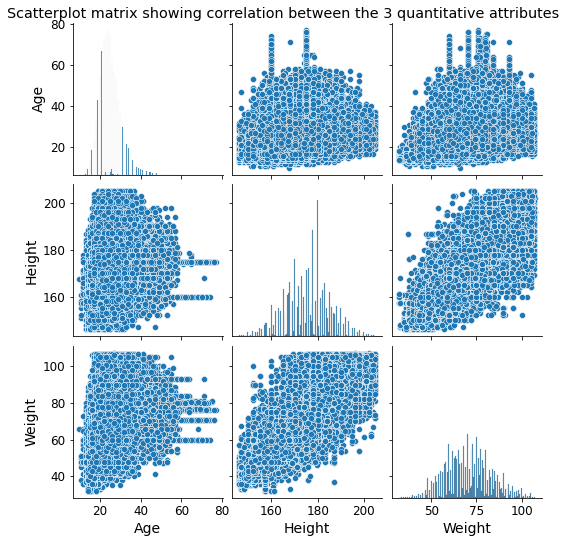

In [497]:
# plt.figure(figsize=(10,10))
g= sns.pairplot(df_olympics[['Age','Height','Weight']])
# plt.title('Scatterplot matrix showing correlation between the 3 quantitative attributes', y=10)
g.fig.suptitle("Scatterplot matrix showing correlation between the 3 quantitative attributes", y =1)

**Performance of female participants versus male participants**


**Ages of participants**

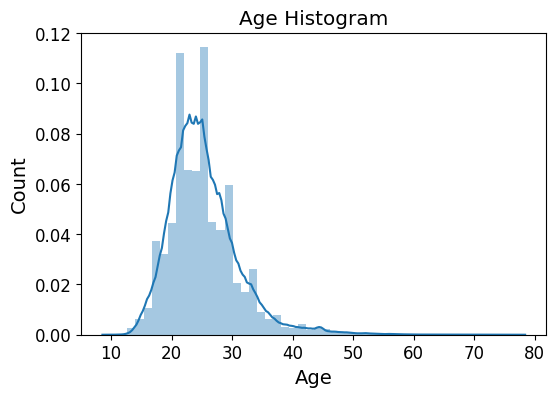

In [498]:
#plot a histogram of age 
bins = [0,10,20,30,40,50,60,70,80,90,100]
fig, axs_1 = plt.subplots(1,1,dpi=100)
axs_1.set_title('Age Histogram')
axs_1.set_xlabel('Age')
axs_1.set_xticks(bins)
# axs_3.set_xlim([35,90]) 
axs_1.set_ylabel('Count')
sns.distplot(df_olympics['Age'])

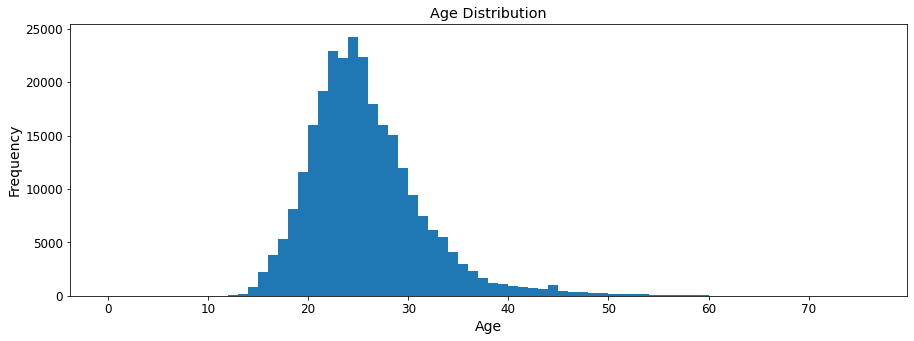

In [499]:
#getting the frequency of the ages (age by age)
plt.figure(figsize=(15,5))
bins = np.arange(0,df_olympics.Age.max())
plt.hist(data=df_olympics, x='Age',bins=bins);
plt.xticks(np.arange(0,df_olympics['Age'].max(),10));
plt.title('Age Distribution');
plt.ylabel('Frequency');
plt.xlabel('Age');

**Weight distribution**

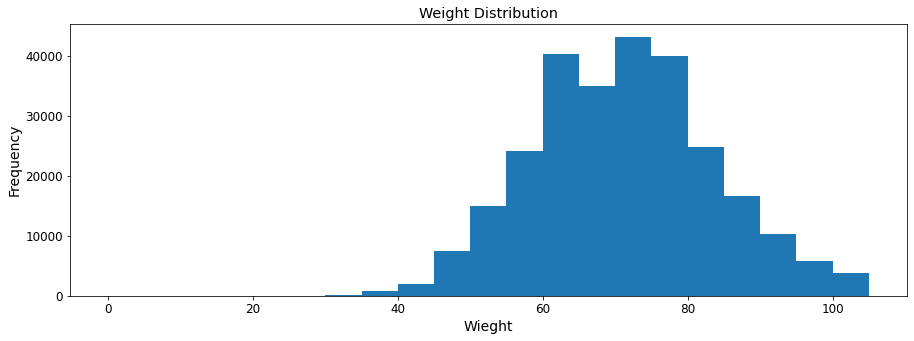

In [500]:
#getting the frequency of the ages (age by age)
plt.figure(figsize=(15,5))
bins = np.arange(0,df_olympics.Weight.max(),5)
plt.hist(data=df_olympics, x='Weight',bins=bins);
# plt.xticks(np.arange(df_olympics['Weight'].min(),df_olympics['Weight'].max(),10));
plt.title('Weight Distribution');
plt.ylabel('Frequency');
plt.xlabel('Wieght');

**Height distribution**

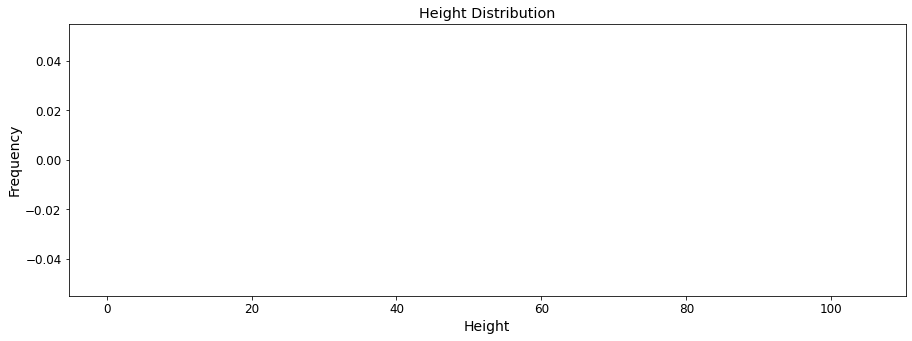

In [501]:
#getting the frequency of the heights
plt.figure(figsize=(15,5))
bins = np.arange(0,df_olympics.Weight.max(),5)
plt.hist(data=df_olympics, x='Height',bins=bins);
# plt.xticks(np.arange(df_olympics['Height'].min(),df_olympics['Height'].max(),10));
plt.title('Height Distribution');
plt.ylabel('Frequency');
plt.xlabel('Height');

**Frequency of players per season over the years**

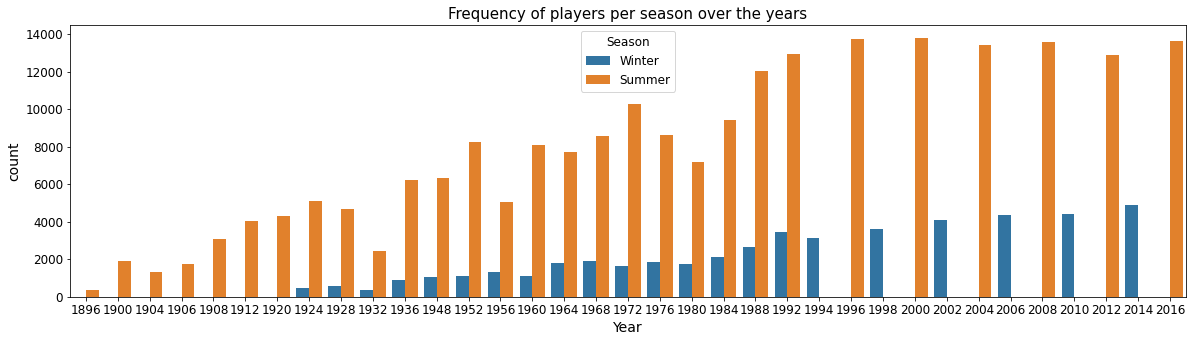

In [502]:
plt.figure(figsize=(20,5))
plt.title('Frequency of players per season over the years', fontsize=15)
sns.countplot(data=df_olympics,x="Year",hue='Season',hue_order=['Winter','Summer'] )

In [503]:
df_olympics.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,region,Medal_Enumarated
0,1,A Dijiang,M,24.000000,180.000000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,China,0
167,20211,Chen Jianghua,M,19.000000,187.000000,73.000000,China,CHN,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Men's Basketball,China,0
168,20211,Chen Jianghua,M,23.000000,187.000000,73.000000,China,CHN,2012 Summer,2012,Summer,London,Basketball,Basketball Men's Basketball,China,0
191,20225,Chen Ke,M,25.000000,204.000000,104.000000,China,CHN,2004 Summer,2004,Summer,Athens,Basketball,Basketball Men's Basketball,China,0
372,20615,Chia Chungchang,M,25.301357,191.853881,88.270621,China,CHN,1948 Summer,1948,Summer,London,Basketball,Basketball Men's Basketball,China,0


Text(0.5, 3.200000000000003, 'Sport')

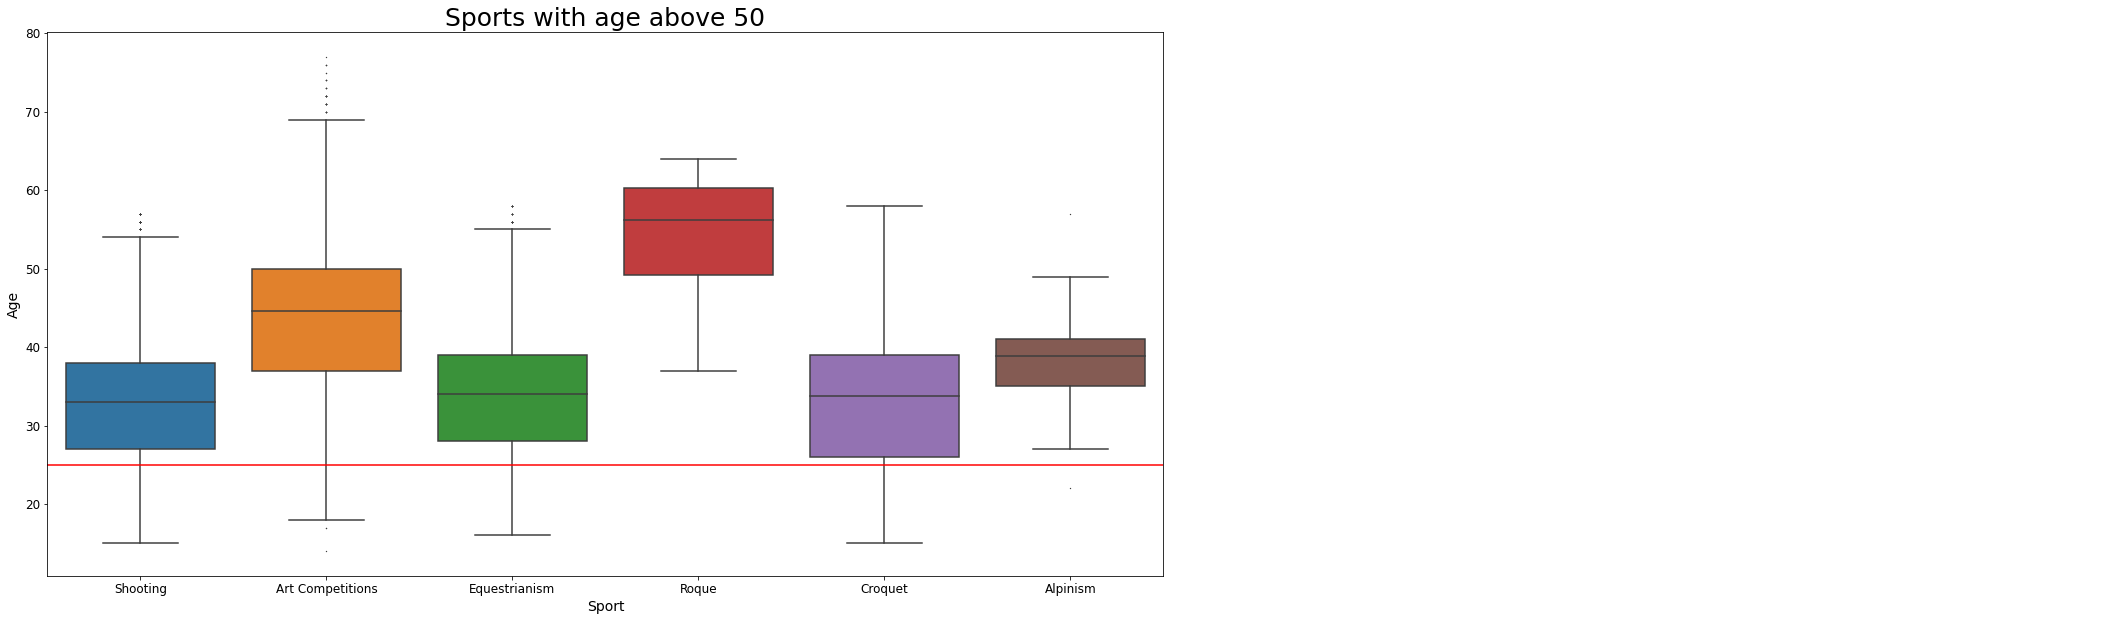

In [504]:
sportsForElders = df_olympics[df_olympics.Age>50].Sport.unique()
plt.figure(figsize=(20,10))
sns.boxplot(data=df_olympics[df_olympics.Sport.isin(sportsForElders)],x='Sport',y='Age',fliersize=1/2)

averageAge = round(df_olympics['Age'].mean())

plt.axhline(averageAge,color='red',linestyle='-')
bbox_props = dict(boxstyle="round,pad=0.75", fc="white", ec="black", lw=2)
plt.annotate('Average Age = '+str(averageAge),(10,averageAge+1),bbox=bbox_props)
plt.title('Sports with age above 50', fontsize=25)
ax.set_ylabel("Age",fontsize=35 )
ax.set_xlabel("Sport",fontsize=35 )

**Top cities hosting the Olympics**

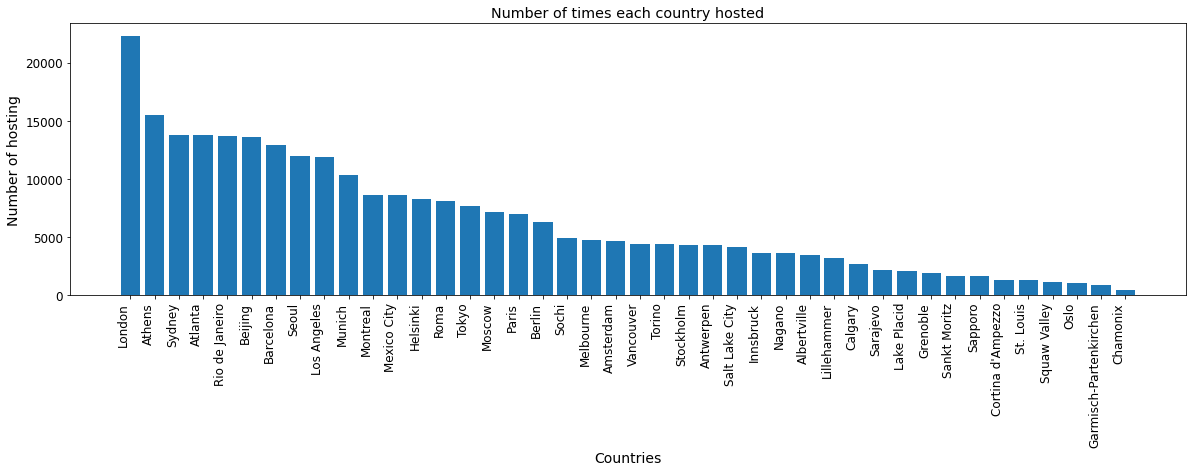

In [505]:
top_hosting_cities_df = df_olympics.groupby(['City'])['ID'].count().sort_values(ascending=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
ax.bar(top_hosting_cities_df.index, top_hosting_cities_df)
ax.set_xticklabels(top_hosting_cities_df.index, rotation=90, ha='right')
ax.set_title('Number of times each country hosted')
ax.set_xlabel('Countries')
ax.set_ylabel('Number of hosting');

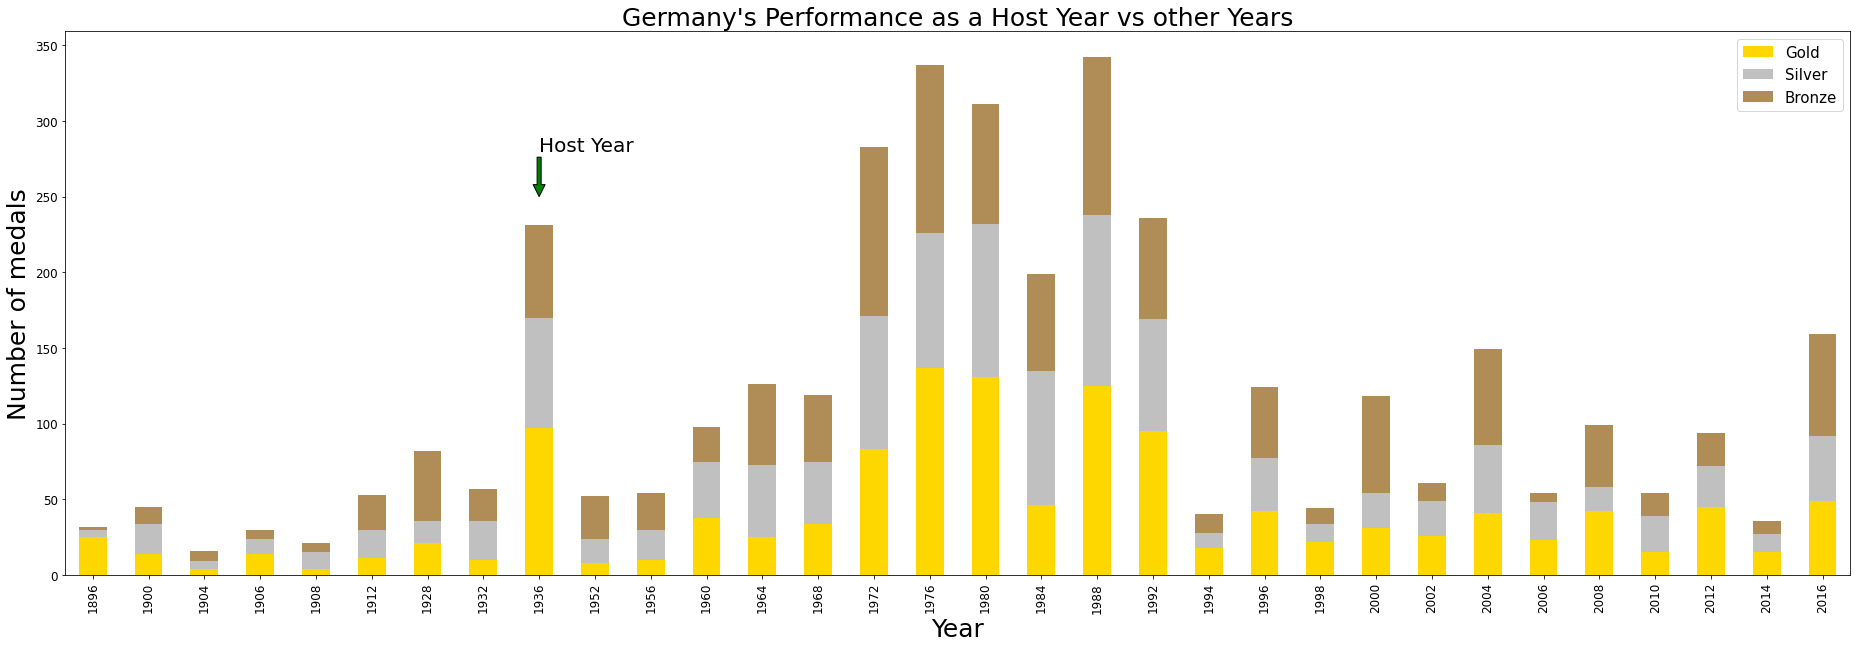

In [506]:
#Difference in Germany Performance in the Host Year vs other Years

RegionGroupData=df_olympics.groupby('region')
  
df_Germany = pd.DataFrame(columns = ['Year', 'Gold', 'Silver' , 'Bronze'])
df_Russia = pd.DataFrame(columns = ['Year', 'Gold', 'Silver' , 'Bronze'])
#df_TOPTWO= pd.DataFrame(columns = ['Year', 'GoldUS', 'SilverUS' , 'BronzeUS', 'GoldRuss', 'SilverRuss' , 'BronzeRuss'])
for i,j in RegionGroupData:
    
    if i=="Germany":
        x=j.groupby("Year")
        for k , l in x:
            Gold,Silver, Bronze =0,0,0 
            Gold = len(l[ l['Medal_Enumarated']==3])
            Silver =len(l[ l['Medal_Enumarated']==2])
            Bronze =len(l[ l['Medal_Enumarated']==1]) 
            new_row={'Year': k , "Gold": Gold, "Silver": Silver , "Bronze": Bronze}  
            df_Germany =  df_Germany.append(new_row, ignore_index=True) 


df=df_olympics[df_olympics['City']=="Berlin"] 
x=df.groupby(["Year"]) 
HostYear=0
for k , j in x:
    HostYear=k
HostYearindex=df_Germany.index[df_Germany['Year']==HostYear].tolist()[0]

# df_Germany.head()

fig, ax = plt.subplots()
   
df_Germany.plot(x='Year', kind='bar', stacked=True
         , color=['#FFD700', '#c0c0c0', '#b08d57']  ,ax=ax  , figsize= (32, 10))
ax.annotate('Host Year', fontsize=20, xy =(HostYearindex,250),
             xytext =(HostYearindex, 280),
             arrowprops = dict(facecolor ='green',
                shrink=2           ))

ax.set_title("Germany's Performance as a Host Year vs other Years" , fontsize=25)
ax.set_ylabel("Number of medals",fontsize=25 )
ax.set_xlabel("Year",fontsize=25 )
ax.legend(['Gold', 'Silver', 'Bronze'], fontsize=15)


In [507]:
df_olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,region,Medal_Enumarated
0,1,A Dijiang,M,24.000000,180.000000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,China,0
167,20211,Chen Jianghua,M,19.000000,187.000000,73.000000,China,CHN,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Men's Basketball,China,0
168,20211,Chen Jianghua,M,23.000000,187.000000,73.000000,China,CHN,2012 Summer,2012,Summer,London,Basketball,Basketball Men's Basketball,China,0
191,20225,Chen Ke,M,25.000000,204.000000,104.000000,China,CHN,2004 Summer,2004,Summer,Athens,Basketball,Basketball Men's Basketball,China,0
372,20615,Chia Chungchang,M,25.301357,191.853881,88.270621,China,CHN,1948 Summer,1948,Summer,London,Basketball,Basketball Men's Basketball,China,0


In [508]:
athletes_winter_df.head()
athletes_winter_df.groupby(['NOC'])['Medal']

Text(0.5, 0.98, 'Top 10 countries in each season versus all')

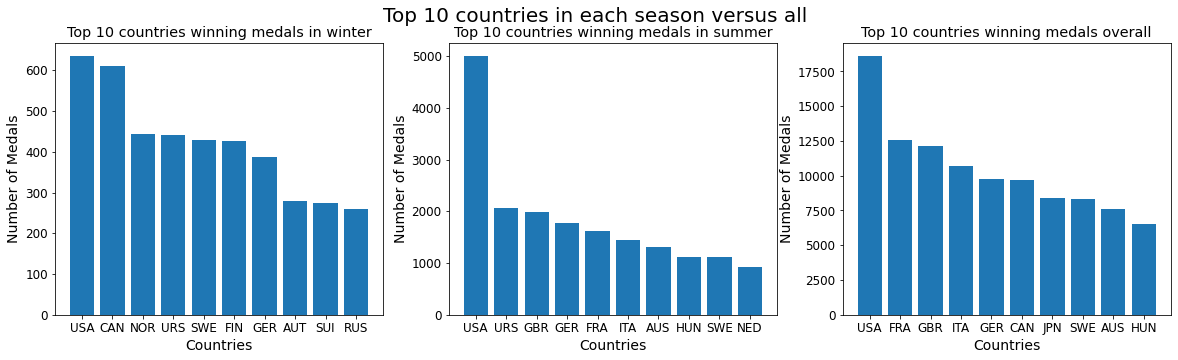

In [509]:
top_countries_with_medals_winter = athletes_winter_df.groupby(['NOC'])['Medal'].count().sort_values(ascending=False)
top_countries_with_medals_summer = athletes_summer_df.groupby(['NOC'])['Medal'].count().sort_values(ascending=False)
countries_medals_count = df_olympics.groupby(['NOC'])['Medal_Enumarated'].count().sort_values(ascending=False)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax1.bar(top_countries_with_medals_winter[:10].index, height=top_countries_with_medals_winter[:10])
ax1.set_xlabel('Countries')
ax1.set_ylabel('Number of Medals');
ax1.set_title('Top 10 countries winning medals in winter')

ax2.bar(top_countries_with_medals_summer[:10].index, height=top_countries_with_medals_summer[:10])
ax2.set_xlabel('Countries')
ax2.set_ylabel('Number of Medals');
ax2.set_title('Top 10 countries winning medals in summer')

ax3.bar(countries_medals_count[:10].index, height=countries_medals_count[:10])
ax3.set_xlabel('Countries')
ax3.set_ylabel('Number of Medals');
ax3.set_title('Top 10 countries winning medals overall')
fig.suptitle('Top 10 countries in each season versus all', fontsize=20)

**Top Athletes**

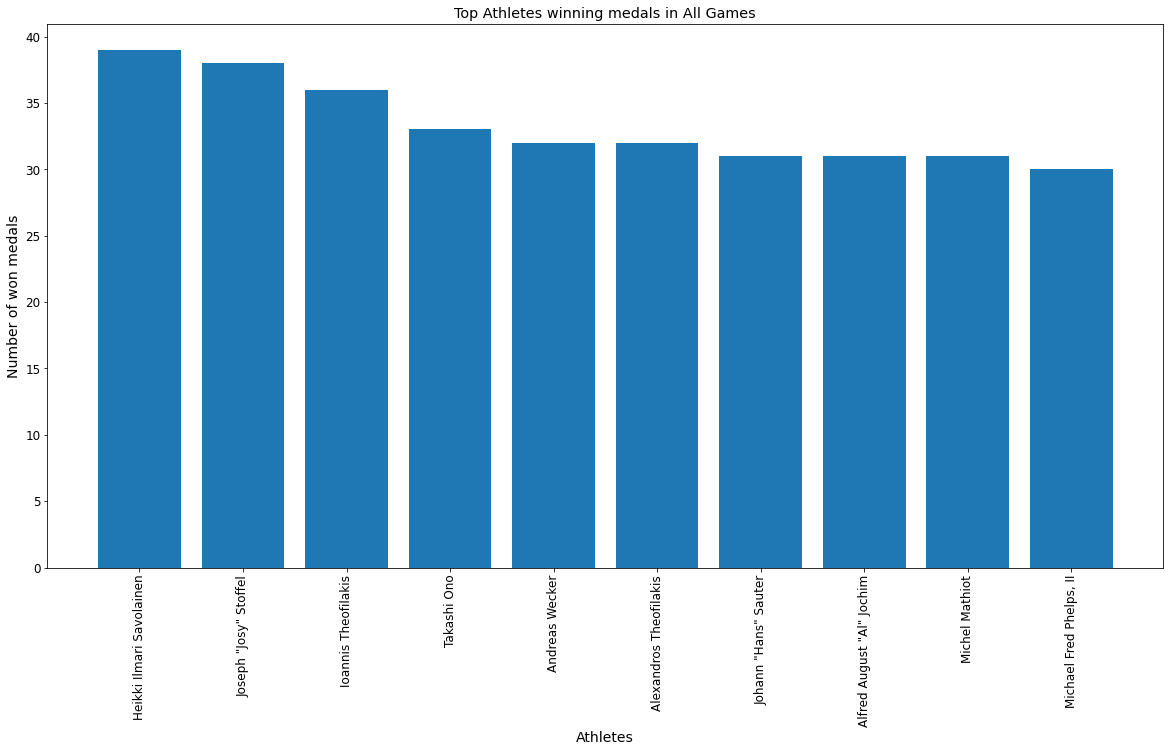

In [510]:
top_athletes_participating = df_olympics.groupby(['Name'])['ID'].count().sort_values(ascending=False)
top_athletes_winning_medals = df_olympics.groupby(['Name'])['Medal_Enumarated'].count().sort_values(ascending=False)

plt.figure(figsize=(20,10))
plt.bar(x=top_athletes_winning_medals[:10].index, height=top_athletes_winning_medals[:10])
plt.title('Top Athletes winning medals in All Games')
plt.xlabel('Athletes')
plt.ylabel('Number of won medals')
plt.xticks(rotation=90);

#**INSIGHTS**

#### ▶ **Olympics Seasons**

We realised that the ranges of the x-labels were inconsistent. After investigating more we found out that olympics occurred every four years, that is in every leap year to be specific. We also found out that winter seasons started in 1994. The Winter and Summer olympics were held in the same years until 1992, where after that the winter games were held after two years from the summer games. 

\
Researching more about the topic we found out that the International Olympic Committee (IOC) decided to place the Summer and Winter Games on separate four-year cycles in alternating even-numbered years. 

\
Note that the gap between 1936 and 1948 was due to World War 2.

---



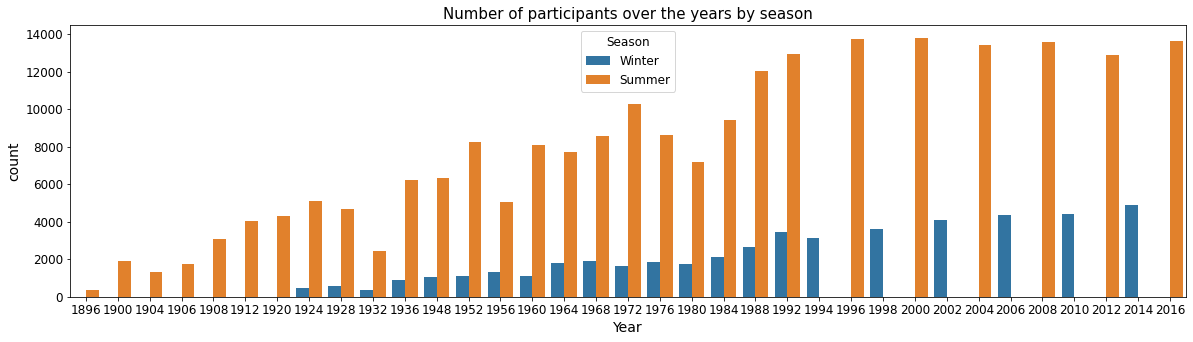

In [511]:
plt.figure(figsize=(20,5))
plt.title("Number of participants over the years by season",fontsize=15)
sns.countplot(data=df_olympics,x="Year",hue='Season',hue_order=['Winter','Summer'] )

#### ▶ **Rivalry between USA and Russia**

We found that the top two countries from number of participants and number of medals were Russia and USA. We decided to observe the rivalry between these two countries, and we found out that although Russia had more participants over the years, but USA won more medals in almost all the years.


In [512]:
df_olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,region,Medal_Enumarated
0,1,A Dijiang,M,24.000000,180.000000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,China,0
167,20211,Chen Jianghua,M,19.000000,187.000000,73.000000,China,CHN,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Men's Basketball,China,0
168,20211,Chen Jianghua,M,23.000000,187.000000,73.000000,China,CHN,2012 Summer,2012,Summer,London,Basketball,Basketball Men's Basketball,China,0
191,20225,Chen Ke,M,25.000000,204.000000,104.000000,China,CHN,2004 Summer,2004,Summer,Athens,Basketball,Basketball Men's Basketball,China,0
372,20615,Chia Chungchang,M,25.301357,191.853881,88.270621,China,CHN,1948 Summer,1948,Summer,London,Basketball,Basketball Men's Basketball,China,0


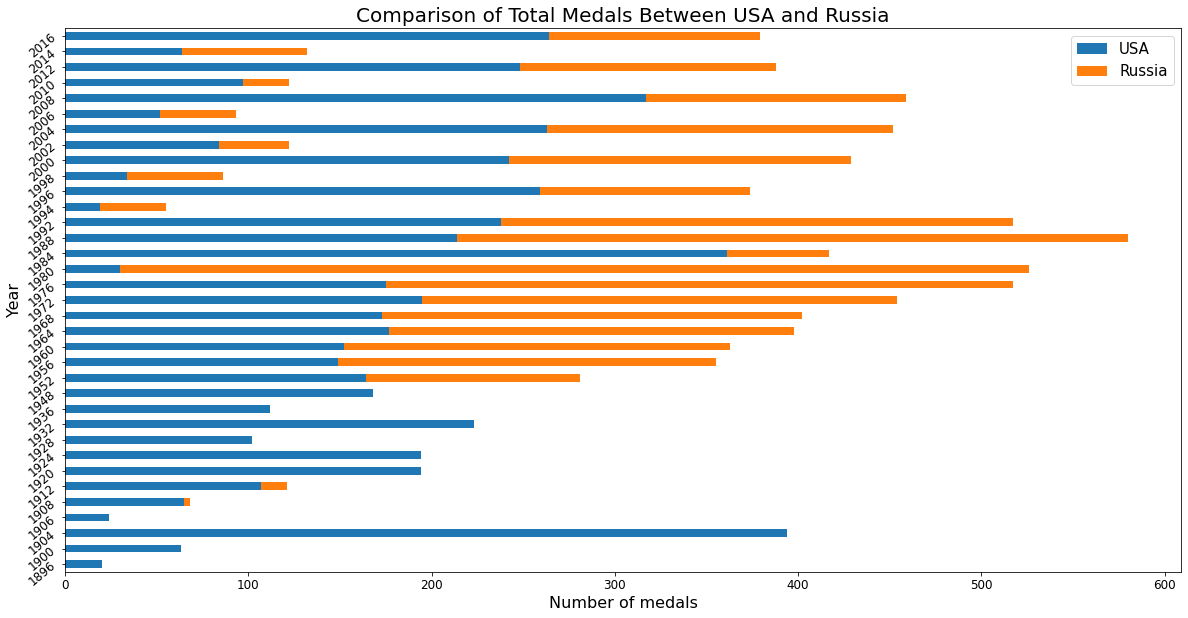

In [513]:
#Comparison between USA and Russia (Top two countries )
YearGroupData=df_olympics.groupby('Year')
  
df_USA = pd.DataFrame(columns = ['Year', 'GoldUS', 'SilverUS' , 'BronzeUS'])
df_Russia = pd.DataFrame(columns = ['Year', 'GoldRuss', 'SilverRuss' , 'BronzeRuss'])
df_TOPTWO= pd.DataFrame(columns = ['Year', 'GoldUS', 'SilverUS' , 'BronzeUS', 'GoldRuss', 'SilverRuss' , 'BronzeRuss'  , 'TotalUs','TotalRuss'])
 
for i,j in YearGroupData:
    GoldUS,SilverUS, BronzeUS, GoldRuss ,SilverRuss , BronzeRuss=0,0,0,0,0,0
    USA=j[j['region']=="USA"]
    Russia=j[j['region']=="Russia"] 
    GoldUS = len(USA[ USA['Medal_Enumarated']==3])
    SilverUS =len(USA[ USA['Medal_Enumarated']==2])
    BronzeUS =len(USA[ USA['Medal_Enumarated']==1])  
    GoldRuss = len( Russia[Russia['Medal_Enumarated']==3])
    SilverRuss =len( Russia[  Russia['Medal_Enumarated']==2])
    BronzeRuss =len( Russia[  Russia['Medal_Enumarated']==1]) 
    totalUS=GoldUS+SilverUS+BronzeUS
    totalRuss=GoldRuss+SilverRuss+BronzeRuss
    new_rowUS={'Year': i ,'GoldUS':GoldUS , 'SilverUS':SilverUS , 'BronzeUS':BronzeUS}  
    new_rowRuss={'Year': i ,'GoldRuss': GoldRuss, 'SilverRuss':SilverRuss , 'BronzeRuss':BronzeRuss}
    df_USA=df_USA.append(new_rowUS,  ignore_index=True)
    df_Russia=df_Russia.append(  new_rowRuss , ignore_index=True)
    new_row2={'Year': i ,'GoldUS':GoldUS , 'SilverUS':SilverUS , 'BronzeUS':BronzeUS, 'GoldRuss': GoldRuss, 'SilverRuss':SilverRuss , 'BronzeRuss':BronzeRuss,'TotalUs':totalUS,'TotalRuss':totalRuss }   
    df_TOPTWO=df_TOPTWO.append(  new_row2 ,  ignore_index=True)
    

ig, ax = plt.subplots(figsize=(20,10))
df_TOPTWO.plot(x = 'Year', y = ['TotalUs','TotalRuss'],kind="barh", stacked=True, rot = 40, ax = ax) 
plt.title('Comparison of Total Medals Between USA and Russia',fontsize=20); 
ax.set_xlabel("Number of medals",fontsize=16 )
ax.set_ylabel("Year",fontsize=16 )
ax.legend(['USA', 'Russia'], fontsize=15)

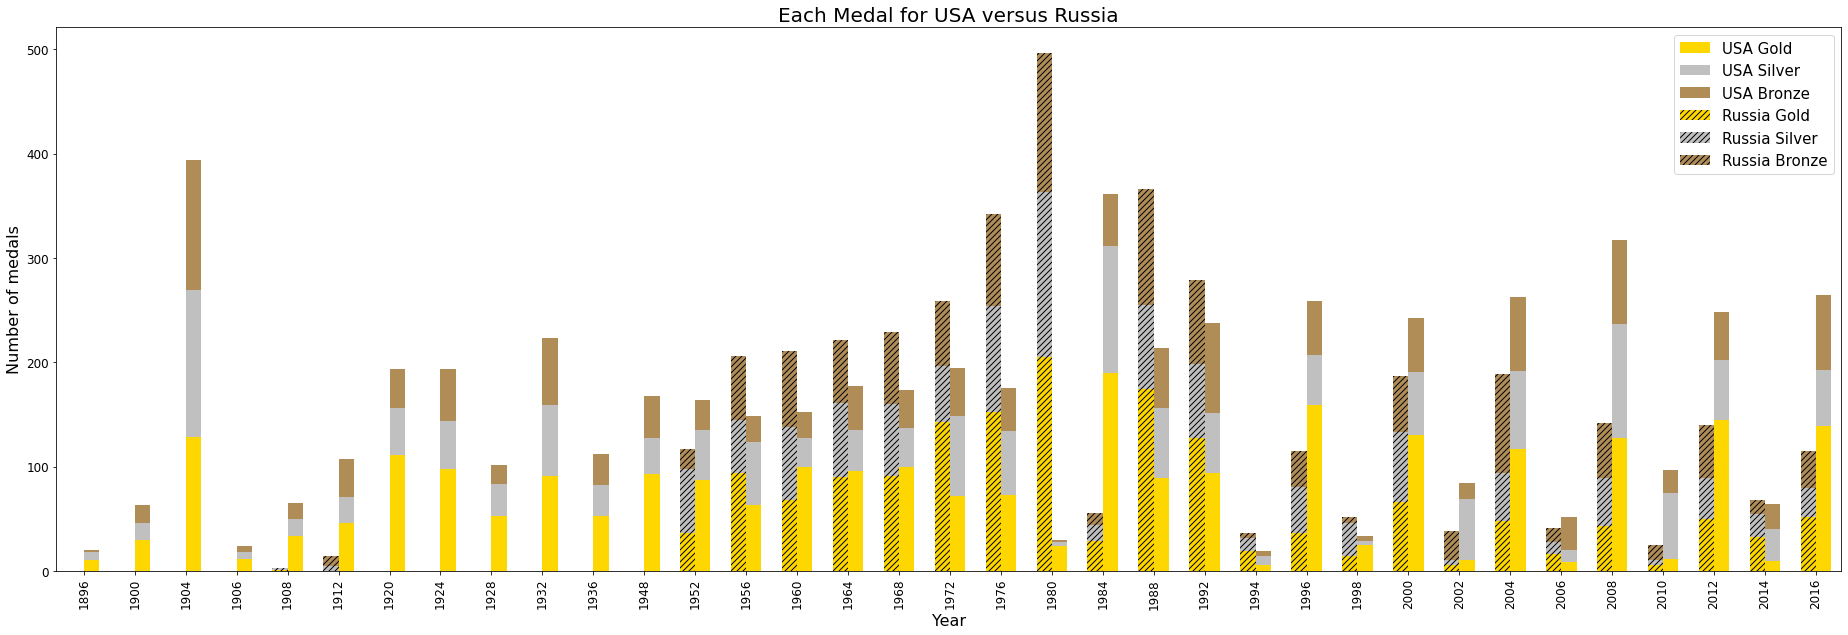

In [514]:
fig, ax = plt.subplots(figsize=(32,10))

df_USA.plot(x = 'Year',kind="bar", stacked=True , color=['#FFD700', '#c0c0c0', '#b08d57'],width=0.3,position=0,
                  ax=ax)
df_Russia.plot(x = 'Year',kind="bar", stacked=True , color=['#FFD700', '#c0c0c0', '#b08d57'],width=0.3, position=1, hatch='////',
                  ax=ax)

ax.set_xlim(right=len(df_USA)-0.5)

ax.set_title('Each Medal for USA versus Russia' , fontsize=20)
ax.set_ylabel("Number of medals",fontsize=16 )
ax.set_xlabel("Year",fontsize=16 )
ax.legend(['USA Gold','USA Silver','USA Bronze', 'Russia Gold','Russia Silver','Russia Bronze'], fontsize=15)

In [515]:
# TODO
# top_countries_apperances = df_olympics.groupby(["Team", "Games"])["Games"].count()
# # top_countries_apperances

# country_appearances = {}

# for country, Games in top_countries_apperances.keys():
#     if country not in country_appearances:
#         country_appearances[country] = top_countries_apperances[country].count()

# top_10_country_appearances = pd.DataFrame.from_dict(country_appearances, columns=['appearances'], orient='index').sort_values(by="appearances", ascending=False)
# # print("Numer of Olympic Games in the dataset" , len(df_olympics["Games"].unique()))
# # df_olympics["Games"].unique()

# plt.bar(top_10_country_appearances.index, top_10_country_appearances)
# plt.xticks(rotation=45)
# plt.title('Top 10 countries appearing in the olympics')
# plt.xlabel('Countries')
# plt.ylabel('Number of appearances');

#**Exploring the research questions**

1. Do the number of medals on the average increase as an athlete participates more?
2. What is the relation between the number of medals and the number of each medal individually?
3. Does the economy of the country affect their performance?
4. What is the estimated number of appearances for a participant to achieve their first medal?
5. What are the performances of both genders?
6. How does hosting events affect a country's performance?
7. What is the peak age per sport?
8. What is the average time for winning the first medal since joining?
9. What is the relation between the number of participants from a country and number of medals relative to the country's population?

#### **1- Do the number of medals on average increase as an athlete participates more?**

We recognised that there is no relationship between the number of participations an athletes does and the number of medals they win. That is unlike what was expected, that participating more increases the chances of winning a medal.

---



**Number of participations for each athlete against number of medals gained**

In [516]:
# frequencyOfParticipations = df_olympics.groupby('Name').size().sort_values(ascending=False).reset_index()
# frequencyOfParticipations.columns = ['Name', 'Number of participation']

# allMedals = df_olympics[df_olympics['Medal_Enumarated'] != 0]
# frequencyOfMedals = allMedals.groupby('Name').size().sort_values(ascending=False).reset_index()
# frequencyOfMedals.columns = ['Name', 'Number of Medals']

# print(len(frequencyOfParticipations))
# print(len(frequencyOfMedals))

# freqParticipantsXMedals = pd.merge(frequencyOfParticipations, frequencyOfMedals, left_on = 'Name', right_on = 'Name')

# fig, ax = plt.subplots(figsize=(20,5))
# ax.set_title('')
# freqParticipantsXMedals.plot.bar(x ='Number of participation' , y ='Number of Medals', ax = ax)

**Frequency of top 10 participants with their corresponding number of medals**



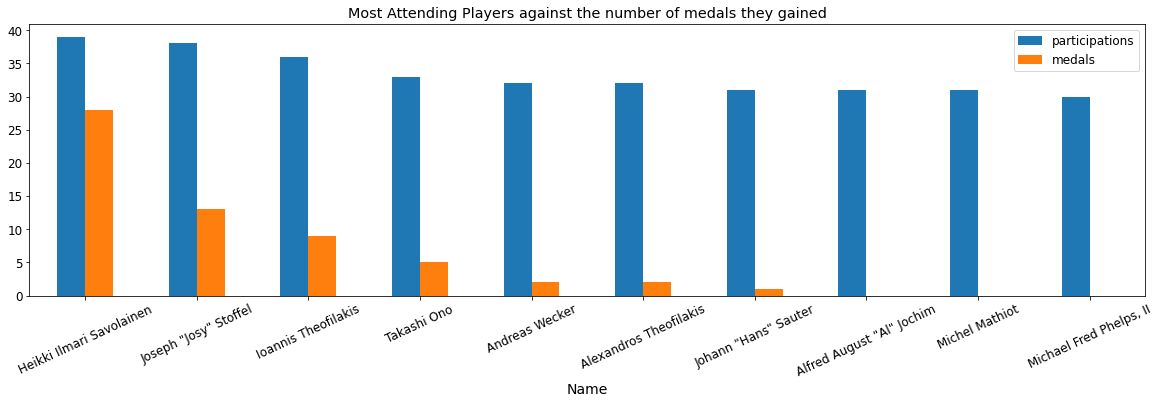

In [517]:
mostFrequentPlayers = df_olympics.groupby('Name').size().sort_values(ascending=False).reset_index().head(10)
mostFrequentPlayers.columns = ['Name', 'participations']

df_mostPlayers =  df_olympics[df_olympics.Name.isin(mostFrequentPlayers.Name)]
df_mostPlayers_medals = df_mostPlayers[df_mostPlayers['Medal_Enumarated'] != 0]

df_mostPlayers_medalsCount = df_mostPlayers_medals.groupby('Name').size().sort_values(ascending=False).reset_index()
df_mostPlayers_medalsCount.columns = ['Name', 'medals']

mostFrequentPlayers['medals'] = df_mostPlayers_medalsCount['medals']

order=df_mostPlayers_medalsCount.index

fig, ax = plt.subplots(figsize=(20,5))
mostFrequentPlayers.plot.bar(x = 'Name', y = ['participations','medals'], rot = 40, ax = ax)

plt.xticks(rotation=25);
plt.title('Most Attending Players against the number of medals they gained');

**Highest performers, based on the number of medals they gained**

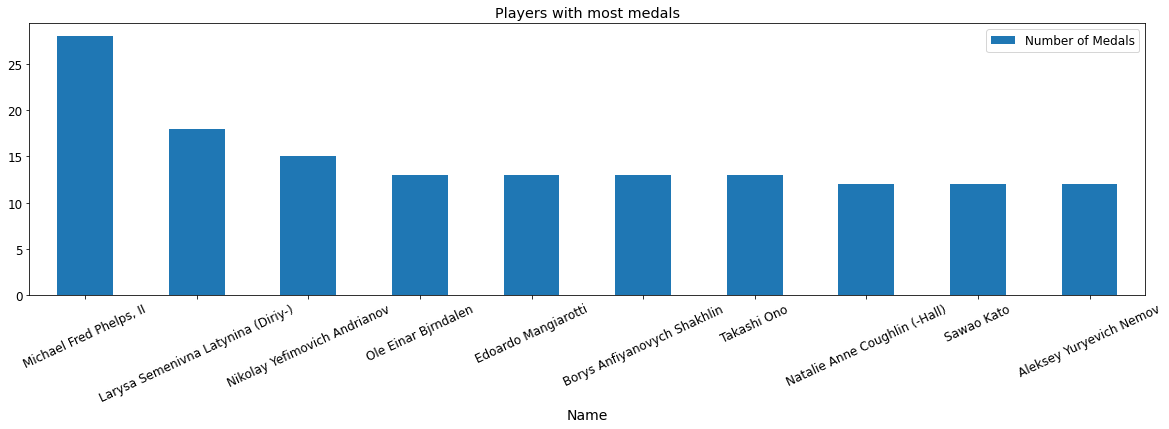

In [518]:
allMedals = df_olympics[df_olympics['Medal_Enumarated'] != 0]
mostPlayersWithMedals = allMedals.groupby('Name').size().sort_values(ascending=False).reset_index().head(10)
mostPlayersWithMedals.columns = ['Name', 'Number of Medals']

order = mostPlayersWithMedals.index

fig, ax = plt.subplots(figsize=(20,5))
mostPlayersWithMedals.plot.bar(x = 'Name', y ='Number of Medals', rot = 40, ax = ax)

plt.xticks(rotation=25);
plt.title('Players with most medals');

#### **2-Do the number of medals related to the number of each medal?**

We recognised that there is a weak positive correlation between the total number of medals and the number of each medal. We draw this conclusion from both, regions and participants.
We also found that the gold medals were gained more, either per region or per athletes, and this was unexpected.

---



In [519]:
topGoldMedals = df_olympics.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==3).sum()).reset_index(name='count')
topSilverMedals = df_olympics.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==2).sum()).reset_index(name='count')
topBronzeMedals = df_olympics.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==1).sum()).reset_index(name='count')

numberOfParticipationPerCountry = df_olympics.groupby('region')['Medal_Enumarated'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)

df_medalHolders = df_olympics[df_olympics['Medal_Enumarated']!= 0]
df_medalHolders_Performance =  df_medalHolders.groupby('region')['Medal_Enumarated'].count().reset_index(name='count').sort_values(by=['count'], ascending=False).head(10)
df_medalHolders_Performance =  df_medalHolders_Performance.sort_values(by=['count'], ascending=True).head(10)

goldMedals = df_medalHolders.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==3).sum()).reset_index(name='gold').sort_values(by=['gold'], ascending=True)
silverMedals = df_medalHolders.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==2).sum()).reset_index(name='silver').sort_values(by=['silver'], ascending=True)
bronzeMedals = df_medalHolders.groupby('region')['Medal_Enumarated'].apply(lambda x: (x==1).sum()).reset_index(name='bronze').sort_values(by=['bronze'], ascending=True)

mergedMedalsCounts = pd.merge(df_medalHolders_Performance, goldMedals,left_on = 'region',right_on = 'region')
mergedMedalsCounts = pd.merge(mergedMedalsCounts, silverMedals,left_on = 'region',right_on = 'region')
mergedMedalsCounts = pd.merge(mergedMedalsCounts, bronzeMedals,left_on = 'region',right_on = 'region')
mergedMedalsCounts


,region,count,gold,silver,bronze
0,Hungary,1135,432,332,371
1,Australia,1349,368,459,522
2,Canada,1352,463,438,451
3,Sweden,1536,479,522,535
4,Italy,1637,575,531,531
5,France,1767,499,602,666
6,UK,2067,677,739,651
7,Germany,3756,1301,1195,1260
8,Russia,3947,1599,1170,1178
9,USA,5637,2638,1641,1358


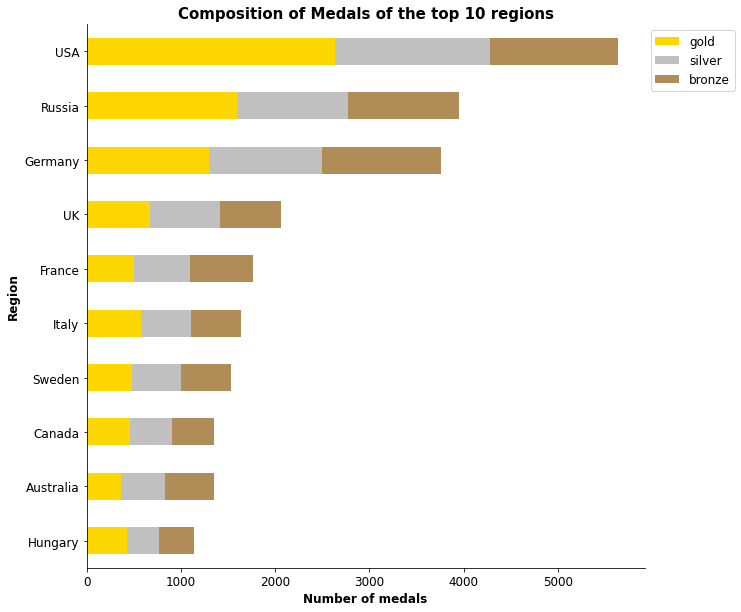

In [520]:
mergedMedalsCounts = mergedMedalsCounts.set_index("region")
mergedMedalsCounts[['gold', 'silver', 'bronze']].head(10).plot(kind='barh', stacked=True, figsize= (10, 10), color=['#FFD700', '#c0c0c0', '#b08d57'])

plt.xlabel("Number of medals", fontsize=12, fontweight="bold")
plt.ylabel("Region", fontsize=12, fontweight="bold")
plt.title('Composition of Medals of the top 10 regions', fontsize=15, weight="bold")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
sns.despine()
ax.legend(['Gold', 'Silver', 'Bronze'], fontsize=15)
plt.show()

In [521]:
topGoldMedals = df_olympics.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==3).sum()).reset_index(name='count')
topSilverMedals = df_olympics.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==2).sum()).reset_index(name='count')
topBronzeMedals = df_olympics.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==1).sum()).reset_index(name='count')

numberOfParticipationPerAthlete = df_olympics.groupby('Name')['Medal_Enumarated'].count().reset_index(name='count').sort_values(by=['count'], ascending=False)

df_medalHolders = df_olympics[df_olympics['Medal_Enumarated']!= 0]
df_medalHolders_Performance =  df_medalHolders.groupby('Name')['Medal_Enumarated'].count().reset_index(name='count').sort_values(by=['count'], ascending=False).head(10)
df_medalHolders_Performance =  df_medalHolders_Performance.sort_values(by=['count'], ascending=True).head(10)

goldMedals = df_medalHolders.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==3).sum()).reset_index(name='gold').sort_values(by=['gold'], ascending=True)
silverMedals = df_medalHolders.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==2).sum()).reset_index(name='silver').sort_values(by=['silver'], ascending=True)
bronzeMedals = df_medalHolders.groupby('Name')['Medal_Enumarated'].apply(lambda x: (x==1).sum()).reset_index(name='bronze').sort_values(by=['bronze'], ascending=True)

mergedMedalsCounts = pd.merge(df_medalHolders_Performance, goldMedals,left_on = 'Name',right_on = 'Name')
mergedMedalsCounts = pd.merge(mergedMedalsCounts, silverMedals,left_on = 'Name',right_on = 'Name')
mergedMedalsCounts = pd.merge(mergedMedalsCounts, bronzeMedals,left_on = 'Name',right_on = 'Name')
mergedMedalsCounts


,Name,count,gold,silver,bronze
0,Ryan Steven Lochte,12,6,3,3
1,Aleksey Yuryevich Nemov,12,4,2,6
2,Sawao Kato,12,8,3,1
3,Takashi Ono,13,5,4,4
4,Ole Einar Bjrndalen,13,8,4,1
5,Edoardo Mangiarotti,13,6,5,2
6,Borys Anfiyanovych Shakhlin,13,7,4,2
7,Nikolay Yefimovich Andrianov,15,7,5,3
8,Larysa Semenivna Latynina (Diriy-),18,9,5,4
9,"Michael Fred Phelps, II",28,23,3,2


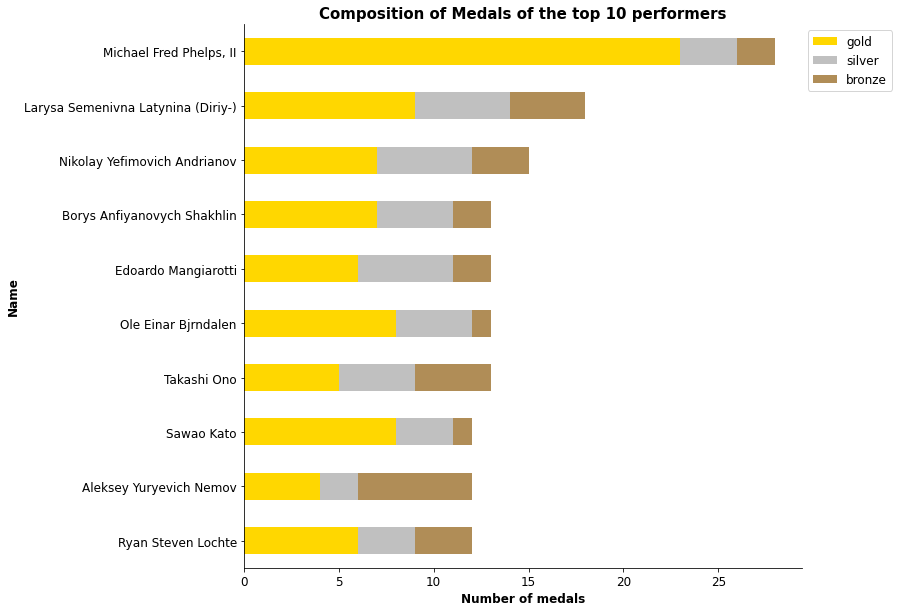

In [522]:
mergedMedalsCounts = mergedMedalsCounts.set_index("Name")
mergedMedalsCounts[['gold', 'silver', 'bronze']].head(10).plot(kind='barh', stacked=True, figsize= (10, 10), color=['#FFD700', '#c0c0c0', '#b08d57'])

plt.xlabel("Number of medals", fontsize=12, fontweight="bold")
plt.ylabel("Name", fontsize=12, fontweight="bold")
plt.title('Composition of Medals of the top 10 performers', fontsize=15, weight="bold")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
sns.despine()
ax.legend(['Gold', 'Silver', 'Bronze'], fontsize=15)
plt.show()

In [523]:
df_olympics

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,region,Medal_Enumarated
0,1,A Dijiang,M,24.000000,180.000000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,China,0
167,20211,Chen Jianghua,M,19.000000,187.000000,73.000000,China,CHN,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Men's Basketball,China,0
168,20211,Chen Jianghua,M,23.000000,187.000000,73.000000,China,CHN,2012 Summer,2012,Summer,London,Basketball,Basketball Men's Basketball,China,0
191,20225,Chen Ke,M,25.000000,204.000000,104.000000,China,CHN,2004 Summer,2004,Summer,Athens,Basketball,Basketball Men's Basketball,China,0
372,20615,Chia Chungchang,M,25.301357,191.853881,88.270621,China,CHN,1948 Summer,1948,Summer,London,Basketball,Basketball Men's Basketball,China,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54000,35364,Jeanne Marie Henriette Filleaul-Brohy (Hantjens-),F,33.000000,167.806353,59.766395,France,FRA,1900 Summer,1900,Summer,Paris,Croquet,"Croquet Mixed Singles, Two Balls",France,0
58525,88258,Marie Pierrette Sophie Pauline Ohier,F,46.000000,167.806353,59.766395,France,FRA,1900 Summer,1900,Summer,Paris,Croquet,"Croquet Mixed Singles, One Ball",France,0
58526,88258,Marie Pierrette Sophie Pauline Ohier,F,46.000000,167.806353,59.766395,France,FRA,1900 Summer,1900,Summer,Paris,Croquet,"Croquet Mixed Singles, Two Balls",France,0
206850,41857,"Sophia Hope Gorham (Hallowes-, -Compton)",F,26.000000,167.806353,59.766395,Quicksilver-2,GBR,1908 Summer,1908,Summer,London,Motorboating,Motorboating Mixed B-Class (Under 60 Feet),UK,0


#### **3- Does economy of the country affect their performance?**
IN PROGRESS

---



#### **4- What is the estimated number of appearances for a participant to achieve their first medal?**
IN PROGRESS


---



#### **5- What are the performances of both genders?**

Overall number of males participants are more than the double of the number of female participants. Also, it seemed that total number of medals won by males were more than medals won by females. This may sound logical considering the ratio of participants.

---



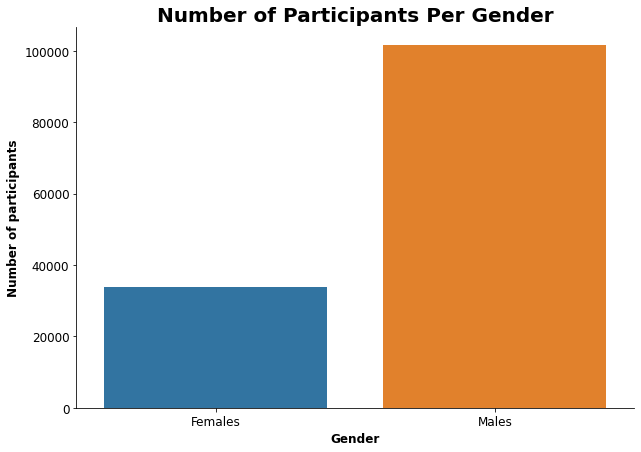

In [524]:
malesCount = len(df_olympics[df_olympics['Sex'] == 'M']['ID'].unique())
femalesCount = len(df_olympics[df_olympics['Sex'] == 'F']['ID'].unique())

plt.figure(figsize=(10,7))
sns.barplot(x=['Females', 'Males'], y = [femalesCount, malesCount])
plt.xlabel('Gender')
# plt.xticks(rotation = 90, )
plt.ylabel('Number of participants', fontsize=12, weight="bold")
plt.title('Number of Participants Per Gender', fontsize = 20, fontweight="bold")
plt.xlabel("Gender", fontsize=12, weight="bold")
sns.despine()
plt.show()

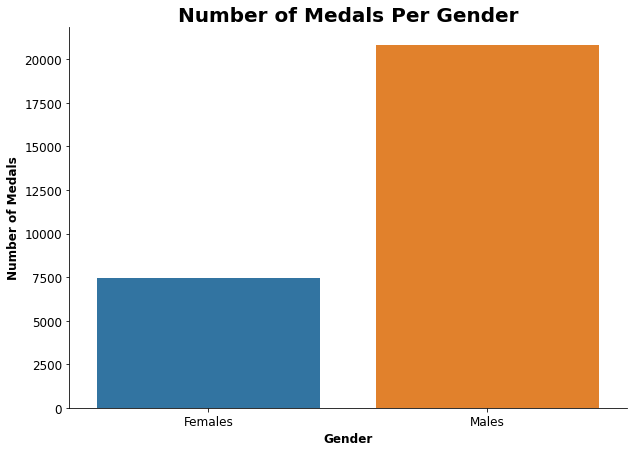

In [525]:
malesCountMedal = len(df_olympics[(df_olympics['Sex'] == 'M') & (df_olympics['Medal_Enumarated'] != 0) ]['ID'].unique())
femalesCountMedal = len(df_olympics[(df_olympics['Sex'] == 'F') & (df_olympics['Medal_Enumarated'] != 0)]['ID'].unique())

plt.figure(figsize=(10,7))
sns.barplot(x=['Females', 'Males'], y = [femalesCountMedal, malesCountMedal])
plt.xlabel('Gender')
# plt.xticks(rotation = 90, )
plt.ylabel('Number of Medals', fontsize=12, weight="bold")
plt.title('Number of Medals Per Gender', fontsize = 20, fontweight="bold")
plt.xlabel("Gender", fontsize=12, weight="bold")
sns.despine()
plt.show()

In [526]:
malesCount

101475

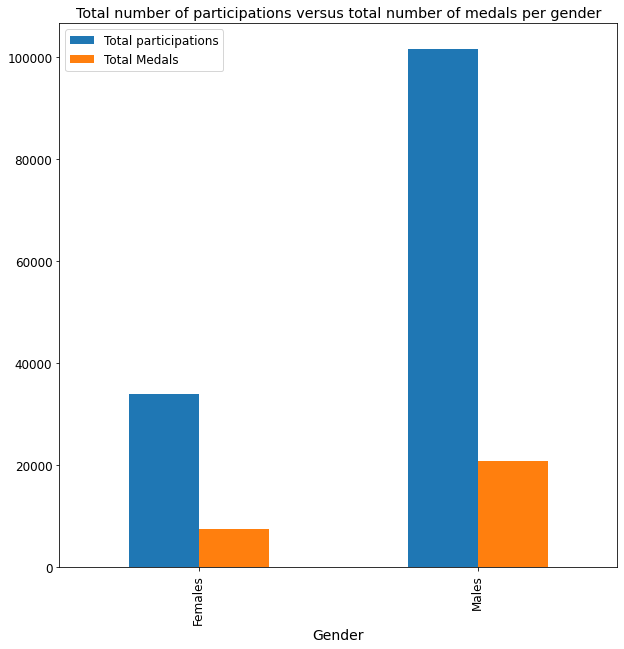

In [527]:
data = [['Females', femalesCount, femalesCountMedal], ['Males', malesCount, malesCountMedal]]

genderRatio = pd.DataFrame(data, columns = ['Gender', 'Total participations', 'Total Medals'])

fig, ax = plt.subplots(figsize=(10,10))
genderRatio.plot.bar(x = 'Gender', y = ['Total participations', 'Total Medals'], ax = ax)
plt.title('Total number of participations versus total number of medals per gender');

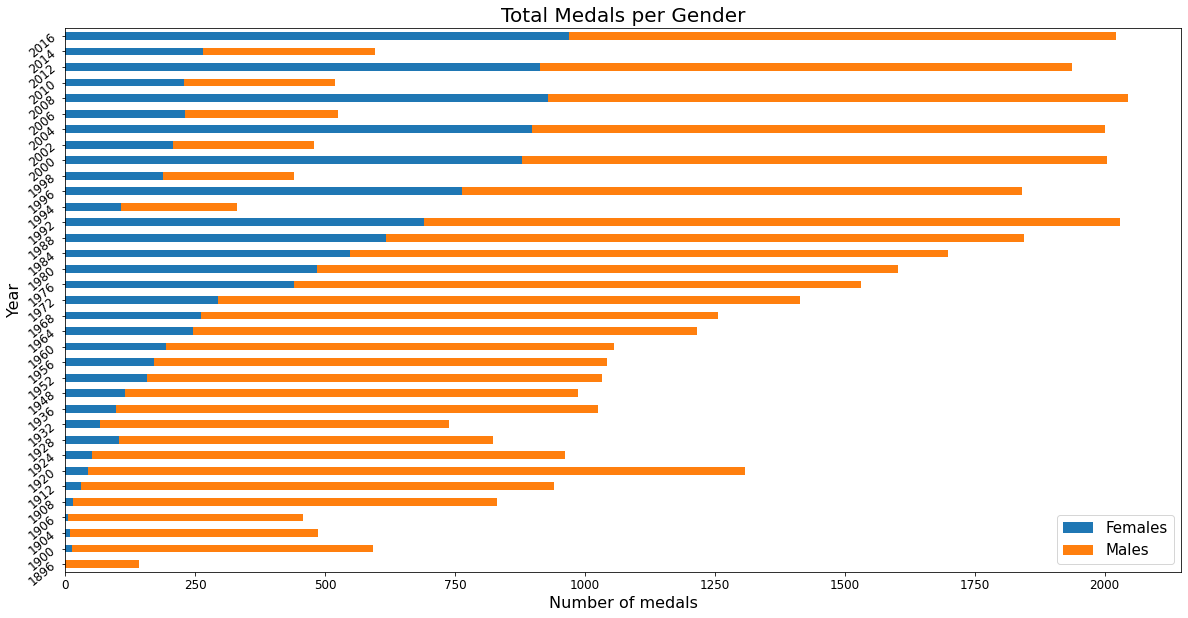

In [528]:
#Comparison between female vs male(Top two countries )
YearGroupData=df_olympics.groupby('Year')
  
df_Female = pd.DataFrame(columns = ['Year', 'Gold_Female', 'Silver_Female' , 'Bronze_Female'])
df_Male = pd.DataFrame(columns = ['Year', 'Gold_Male', 'Silver_Male' , 'Bronze_Male'])
df_F_M= pd.DataFrame(columns = ['Year', 'GoldF', 'SilverF' , 'BronzeF', 'GoldM', 'SilverM' , 'BronzeM','TotalF','TotalM'])
 
for i,j in YearGroupData:
    GoldF, SilverF, BronzeF, GoldM, SilverM, BronzeM=0,0,0,0,0,0
    female=j[j['Sex']=="F"]
    male=j[j['Sex']=="M"] 
    GoldF = len(female[ female['Medal_Enumarated']==3])
    SilverF =len(female[ female['Medal_Enumarated']==2])
    BronzeF =len(female[ female['Medal_Enumarated']==1])  
    GoldM = len( male[male['Medal_Enumarated']==3])
    SilverM =len( male[ male['Medal_Enumarated']==2])
    BronzeM =len( male[  male['Medal_Enumarated']==1])
    totalF=GoldF+SilverF+BronzeF
    totalM=GoldM+SilverM+BronzeM
    new_rowF={'Year': i ,'Gold_Female':GoldF , 'Silver_Female': SilverF , 'Bronze_Female': BronzeF}  
    new_rowM={'Year': i ,'Gold_Male': GoldM , 'Silver_Male':SilverM , 'Bronze_Male': BronzeM}
    df_Female =df_Female.append(new_rowF,  ignore_index=True)
    df_Male=df_Male.append( new_rowM , ignore_index=True)  
    new_row2={'Year': i ,'GoldF':GoldF , 'SilverF': SilverF , 'BronzeF':BronzeF, 'GoldM': GoldM, 'SilverM':SilverM , 'BronzeM':BronzeM ,'TotalF':totalF,'TotalM':totalM }   
    df_F_M=df_F_M.append(  new_row2 ,  ignore_index=True)

fig, ax = plt.subplots(figsize=(20,10))
df_F_M.plot(x = 'Year', y = ['TotalF','TotalM'], kind="barh", stacked=True, rot = 40, ax = ax) 
plt.title('Total Medals per Gender',fontsize=20); 
 
#ax.set_title('Difference in Germany Performance in the Host Year vs other Years' , fontsize=30)
ax.set_xlabel("Number of medals",fontsize=16 )
ax.set_ylabel("Year",fontsize=16)
ax.legend(['Females', 'Males'], fontsize=15)


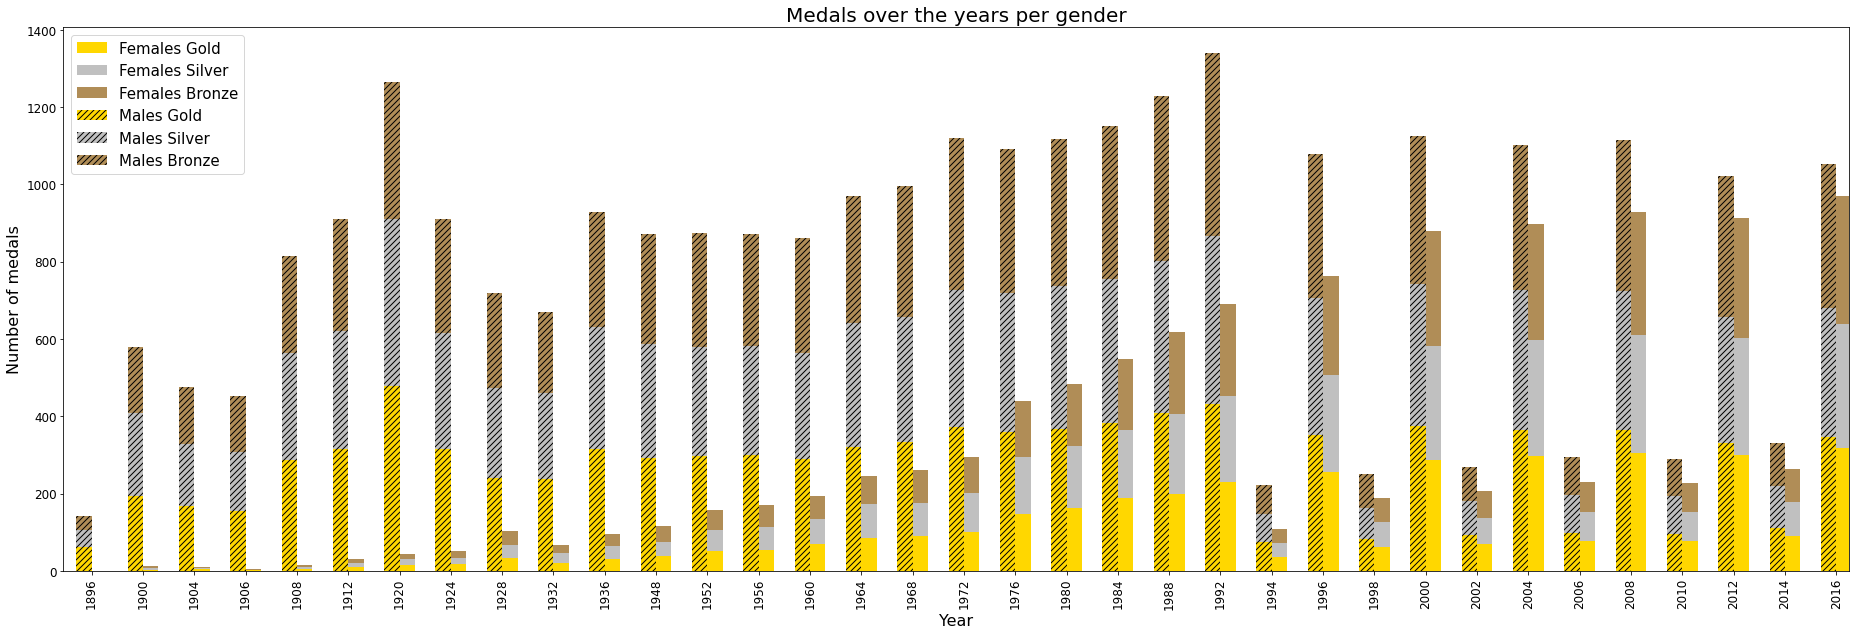

In [529]:
fig, ax = plt.subplots(figsize=(32,10))

df_Female.plot(x = 'Year',kind="bar", stacked=True , color=['#FFD700', '#c0c0c0', '#b08d57'],width=0.3,position=0, ax=ax)
df_Male.plot(x = 'Year',kind="bar", stacked=True , color=['#FFD700', '#c0c0c0', '#b08d57'],width=0.3, position=1, hatch='////', ax=ax)


ax.set_title('Medals over the years per gender' , fontsize=20)
ax.set_ylabel("Number of medals",fontsize=16 )
ax.set_xlabel("Year",fontsize=16 )
ax.legend(['Females Gold', 'Females Silver', 'Females Bronze', 'Males Gold', 'Males Silver', 'Males Bronze'], fontsize=15)

#### **6- How hosting events affects country's performance?**
IN PROGRESS


---



#### **7- What is the peak age per sport?**
IN PROGRESS


---



#### **8- What is the average time for winning the first medal since joining?**
IN PROGRESS


---



#### **9- What is the relation between the number of participants from a country and number of medals relative to the country's population?**
IN PROGRESS


---

